### TP 3 :

###### Group : Alexandre BOISTARD, William ROCHE, Ethan TRENTIN

In [49]:
import numpy
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import statsmodels
from statsmodels import api
from tqdm import tqdm
import Hawkes as hwk

First, let's implement a function that simulates one path of a Hawkes process with a generic decreasing kernel using the thinning algorithm.

For both the thinning and the branching algorithm, we will require the definition of a generic decreasing kernel. We will implement a single exponential kernel in the following function.

In [28]:
def exponential_kernel(t, alpha, beta):
    """This function takes three arguments :
    - t : the time of the event
    - alpha
    - beta
    It returns the value of the exponential kernel at time t."""
    return alpha*numpy.exp(-beta*numpy.where(t>=0, t, numpy.inf)) # We want to choose t when t >= 0 and numpy.inf when t < 0 as we need to model an indicator function.

The implementation of the Hawkes process using the thinning algorithm uses the methodology described in the slide 11 of the lesson on Hawkes processes.

In [29]:
def thinning_Hawkes_process(T, kernel_func, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    """This function takes five arguments :
    - T : the time horizon of the simulation
    - kernel_func : the kernel function (here we will use the exponential kernel in the notebook)
    - alpha : one parameter of the kernel function
    - beta : the other parameter of the kernel function
    - lambda_0 : the initial intensity of the process
    The last three are optional parameters as we will use the same values in the notebook.
    It returns a list of events of the Hawkes process."""
    # First we initialize the time, the lambda_star (the maximum of the intensity function) and the lambda_t. We also create an empty list of events and a variable to store the incrementation of the kernel contribution.
    t = 0
    lambda_star = lambda_0
    lambda_t = lambda_0
    events = []
    added=False
    S_t = alpha
    while t < T:
        # We generate a new event candidate as following a uniform distribution and update the time t.
        U = numpy.random.uniform(0,1)
        t -= numpy.log(U)/lambda_star
        if t >= T:
            return events
        # Next, we do the thinning step by generating a uniform random variable D.
        D = numpy.random.uniform(0,1)
        # We assign a value to lambda_t using the formula of the conditional intensity of a Hawkes process. We use the exponential kernel which means we can benefit from its memoryless property and store the incrementation of the kernel contribution.
        if events:
          if added:
            S_t = numpy.exp(-beta * (t - events[-1])) * S_t
            lambda_t = lambda_0 + S_t
          else:
            S_t = sum(kernel_func(t - ti, alpha, beta) for ti in events)
            lambda_t = lambda_0 + S_t
        # Now, we check is D is less than or equal to lambda_t/lambda_star. If it is, we add the event to the list of events and update lambda_star. Otherwise, we just update lambda_star.
        if D <= lambda_t/lambda_star:
            events.append(t)
            added=True
            lambda_star = lambda_t+alpha
        else:
            added=False
            lambda_star = lambda_t
    return events

Next, we are going to write a function that simulates one path of a Hawkes process with a generic decreasing kernel (again we will use the exponential kernel) using the branching algorithm.

To do so, we need first to implement the simulation of a non-homogeneous poisson process. We will use the code from lab 2 implemented with a global thinning algorithm.

In [30]:
def simulate_nonhomogeneous_poisson(start, end, mu, mu_max=1):
    """This function generates a non-homogeneous poisson process. It has 4 parameters :
    - start : the starting time of the process
    - end : the ending time of the process
    - mu : the intensity function of the process (it is a function of time)
    - mu_max : the maximum value of the intensity function (it is an optional parameter of the thinning algorithm).
    It returns a list of events of the non-homogeneous Poisson process."""
    events = []
    t = start
    # We generate realizations of a time-homogeneous Poisson process with parameter mu_max, and then we generate a uniform random variable that we compare to mu(t)/mu_max. We add to the events the set of points for which the uniform random variable is inferior or equal to mu(t)/mu_max.
    while t < end:
        t += numpy.random.exponential(1 / mu_max)
        if t >= end:
            break

        if numpy.random.uniform(0, 1) <= mu(t) / mu_max:
            events.append(t)

    return events

In [31]:
def branching_Hawkes_process(T, kernel_func, alpha=0.6, beta=0.8, lambda_0=1.2):
    """This function takes five arguments :
    - T : the time horizon of the Hawkes process
    - kernel_func : the kernel function used in the algorithm
    - alpha : one parameter of the kernel function (optional parameter)
    - beta : the other parameter of the kernel function (optional parameter)
    - lambda_0 : the intensity of the process (optional parameter).
    It returns a list of events of the Hawkes process."""
    t = 0
    poissons = []
    # We first generate a time-homogeneous Poisson process with intensity lambda_0 on [0,T].
    while t < T:
        t += numpy.random.exponential(1/lambda_0)
        if t<T:
            poissons.append(t)
    new_pt = True
    Ti1 = poissons.copy()
    # Now, for each event of the Poisson process, we generate a non-homogeneous Poisson process with intensity kernel_func(t-pt) with pt the time of the event of the Poisson process. We repeat this operation for the times of the newly generated process, and so on until there is no new point generated in [0,T], hence the usage of the new_pt variable.
    while new_pt:
        new_pt = False
        Ti2 = []
        for pt in Ti1:
            Ti3 = simulate_nonhomogeneous_poisson(pt,T,lambda t:kernel_func(t-pt, alpha, beta),1)
            if Ti3:
                new_pt = True
                Ti2.extend(Ti3)
        Ti1 = Ti2.copy()
        poissons.extend(Ti2)
    # We returned the ordered set of all the points that we generated to get a Hawkes Process.
    return numpy.sort(poissons)

Now, to visualize the results of our algorithms, we are going to plot the Hawkes processes resulting from both the thinning and the branching algorithms.

In [32]:
def plot_Hawkes(events, T, algorithm, kernel_func, kernel_name, alpha = 0.6, beta = 0.8, lambda_0=1.2):
    """This function takes seven arguments :
    - events : the list of events of the Hawkes process we want to visualize
    - T : the time horizon of the process
    - algorithm : the algorithm used to generate the process (thinning or branching)
    - kernel_func : the kernel function used in the algorithm
    - kernel_name : the kernel function name to display in the title of the plot
    - alpha : one parameter of the kernel function (optional parameter)
    - beta : the other parameter of the kernel function (optional parameter)
    - lambda_0 : the intensity of the process (optional parameter).
    It plots the simulation of one path of the generated Hawkes process."""
    interval = numpy.linspace(0,T,1000)
    # We initialize the intensity values to lambda_0.
    values = numpy.zeros(1000)+lambda_0
    # We then update the intensity with the kernel_func evaluated on interval-event.
    for event in events:
        values += kernel_func(interval-event, alpha, beta)
    # We then find the local maxima of the intensity function using scipy.signal.find_peaks to display the intensity maximum as a piecewise constant function.
    peaks, _ = scipy.signal.find_peaks(values)
    local_maxima = values[peaks]
    max_intensity = numpy.zeros(1000)+lambda_0
    current_max = lambda_0
    for i,peak in enumerate(peaks):
        max_intensity[peak:] = local_maxima[i]
    # We then plot the events and the intensity functions.
    plt.figure(figsize=(10,6))
    plt.scatter(events, numpy.ones(len(events)), color = 'blue', marker = '^', facecolors='none', label='Events')
    plt.plot(interval, values, color='red', label='Intensity $\lambda$')
    plt.plot(interval, max_intensity, color='green', linestyle='--', label='Intensity maximum $\lambda^*$')
    plt.title(f"Simulation of one path of a Hawkes process with the {algorithm} algorithm and the {kernel_name} kernel")
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.grid()
    plt.legend()
    plt.show()

In [33]:
# We choose a value of the time horizon parameter.
T = 10

Let's check that our thinning and branching algorithms correctly return the times of the Hawkes process generated.

In [34]:
test_Hawkes_thinning, test_Hawkes_branching= thinning_Hawkes_process(T, exponential_kernel), branching_Hawkes_process(T,exponential_kernel)
test_Hawkes_thinning, test_Hawkes_branching

([np.float64(1.782132862931332),
  np.float64(1.9430828366411064),
  np.float64(1.963066747368958),
  np.float64(2.567681579146839),
  np.float64(2.700996829563642),
  np.float64(4.989869286642859),
  np.float64(6.801038872698587),
  np.float64(8.178974878874893),
  np.float64(9.101847438824128),
  np.float64(9.847996752000068)],
 array([0.40675523, 1.83601719, 2.46084901, 2.55671536, 2.61837664,
        2.99778162, 3.87090766, 3.95191105, 4.73447159, 4.80930277,
        4.98571055, 5.27159848, 6.08492433, 6.34073207, 6.45767627,
        6.59254962, 7.18566019, 7.22662403, 8.3158313 , 8.68868319,
        9.55229192, 9.86102468]))

And now, we will visualize the Hawkes process created thanks to the thinning and branching algorithm.

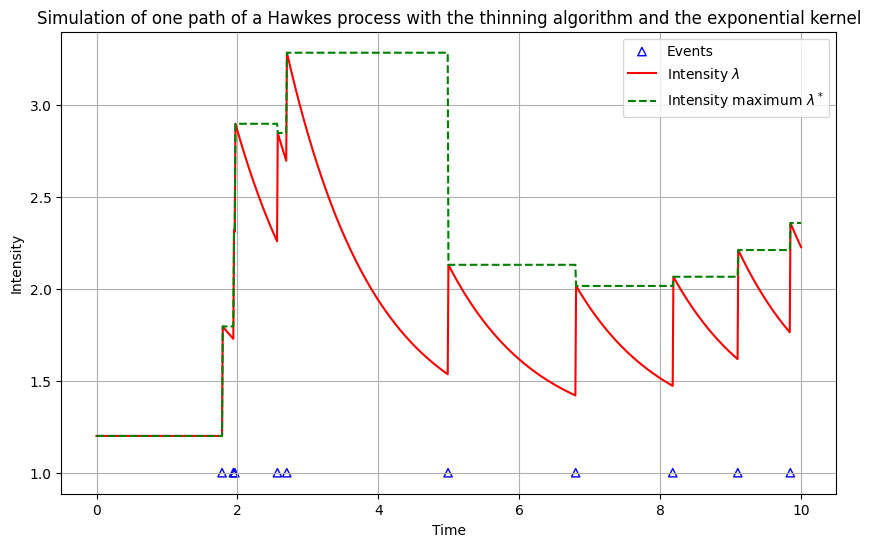

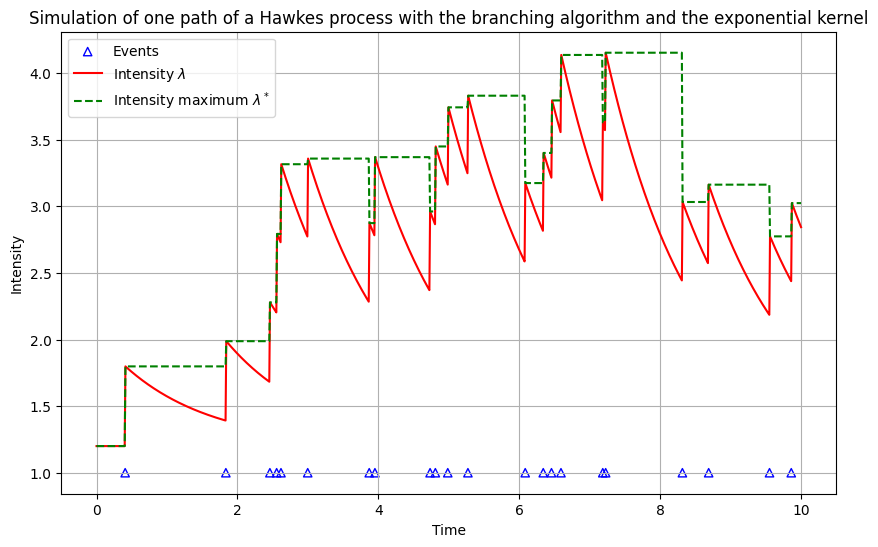

In [35]:
plot_Hawkes(test_Hawkes_thinning, T, "thinning", exponential_kernel, "exponential")
plot_Hawkes(test_Hawkes_branching, T, "branching", exponential_kernel, "exponential")

Comments : These plots display the simulation of one path of a Hawkes process with first the thinning and then the branching algorithm. For both, we plotted the intensity of the process, the times of occurrences of the events (with a triangle symbol) and the intensity maximum as a piecewise function made thanks to local maxima values. We can see that those figures have a similar shape to the ones obtained in class.

The events in a Hawkes process can trigger subsequent events, creating a self-exciting process with clustering of events over time. We can find such clusters of events in our plots.

When an event occurs, the intensity of the process increases immediatly after. This again is a proof of the self-exciting nature of the process and is modeled here by the exponential kernel that we use : close to the event, the intensity spikes and then decays exponentially over time. This reflects sudden jumps of the process.

Therefore, the plot effectively demonstrates the dynamics of a Hawkes process with an exponential kernel : we can see the self-exciting nature of the process and the exponential decay after spikes in the intensity due to the trigerring of events.

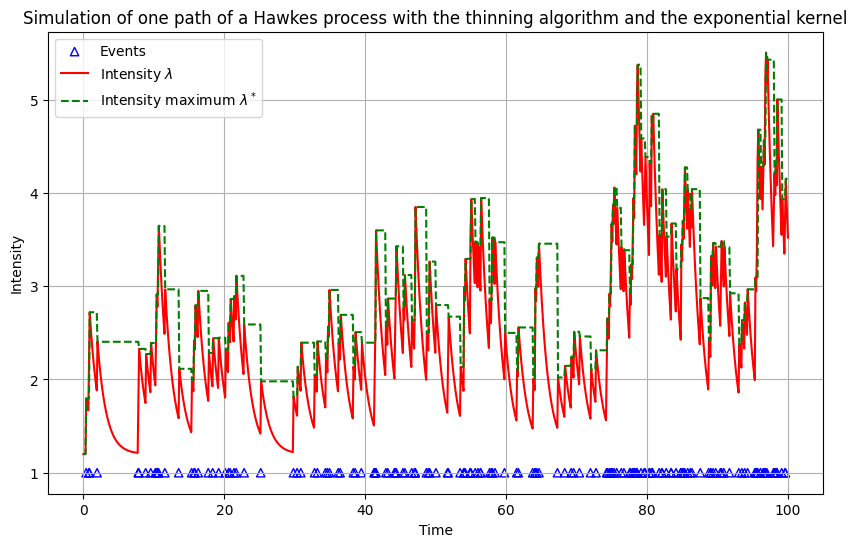

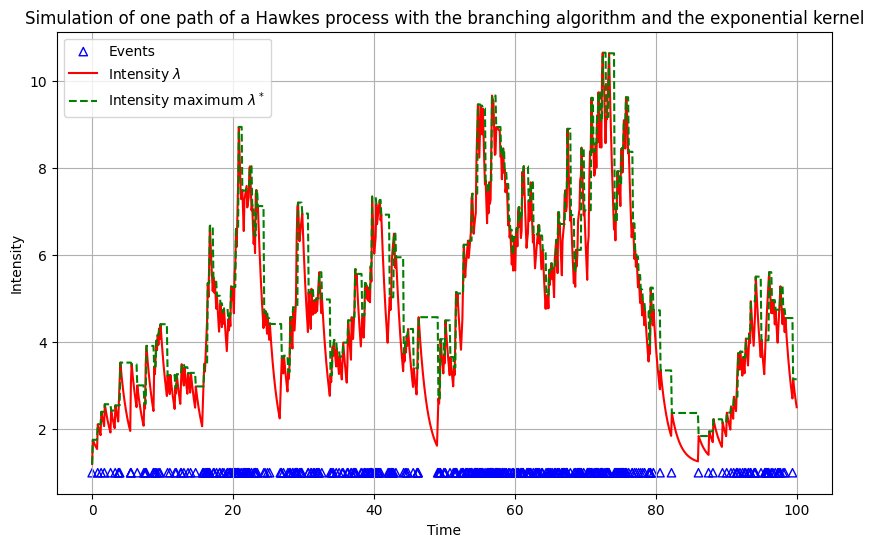

In [36]:
T = 100
plot_Hawkes(thinning_Hawkes_process(T, exponential_kernel), T, "thinning", exponential_kernel, "exponential")
plot_Hawkes(branching_Hawkes_process(T,exponential_kernel), T, "branching", exponential_kernel, "exponential")

Comments : When increasing the time horizon, many more events are displayed, making it sometimes harder to visualize the clustering of events. But the same caracteristics of the Hawkes process can be found, just less visible due to the time scale and the many spikes in intensity.

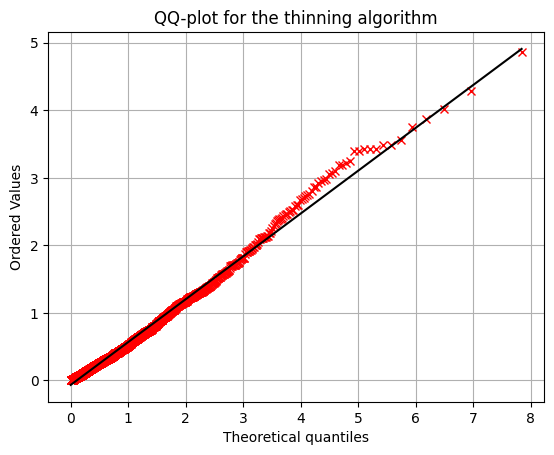

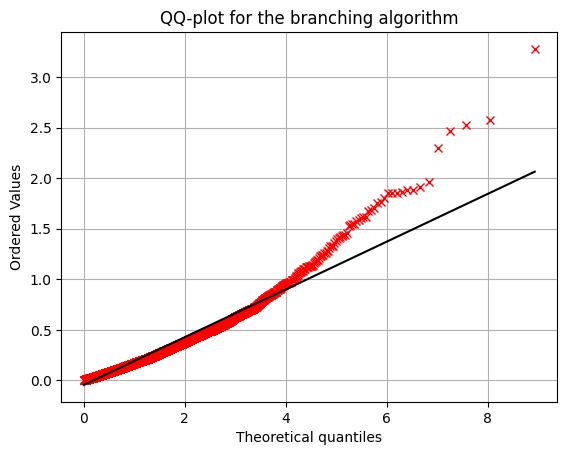

In [37]:
def qq_plot_hawkes(events, algorithm):
    """This function takes two arguments :
    - events : a list of events generated thanks to thinning or branching algorithm
    - algorithm : the name of the algorithm that was used to generate the events
    It plots the QQ-plot of the interval times between events, that are supposed to follow an exponential law if the events were correctly generated."""
    # First, we compute the array of interval times between events.
    inter_event_times = numpy.diff(events)
    fig, ax = plt.subplots()
    res = scipy.stats.probplot(inter_event_times, dist="expon", plot=plt)
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[0].set_marker('x')
    ax.get_lines()[0].set_color('red')
    plt.title(f"QQ-plot for the {algorithm} algorithm")
    plt.grid()
    plt.show()

# To have many points in the goodness-of-fit test, we increased the time horizon.
T = 1000
qq_plot_hawkes(thinning_Hawkes_process(T, exponential_kernel), "thinning")
qq_plot_hawkes(branching_Hawkes_process(T, exponential_kernel), "branching")

Comments : those plots display the QQ-plot of the interval times of the Hawkes processes generated thanks to the thinning and the branching algorithms. It compares the empirical quantiles of the distribution vs the theoretical quantiles of the exponential distribution (that the interval times are supposed to follow).

We can see that the thinning algorithm seems to generate better exponentially distributed interval times. Indeed, the points are closer to the theoretical line. However, this generally confirms that we succeeded in generating Hawkes process (even if the tails of the interval times are fatter than expected in the branching algorithm).

Let's focus now on the properties of Hawkes MLE estimates.

Question 1 : **Properties of Hawkes MLE estimates**. Check that MLE estimators computed with the Hawkes library on samples simulated by our simulators exhibit expected statistical properties.

In [38]:
def MLE_parameters_estimations(algorithm, kernel_func, kernel_name, T, 
                               real_path=None):
    """This function takes four arguments :
    - algorithm : the name of the algorithm used
    - kernel_func : the kernel function used in the algorithm
    - kernel_name : the name of the kernel function used
    - T : the time horizon
    It returns the estimations of the parameters found with the Hawkes library simulated on our samples generated with both the thinning and the branching algorithms."""
    if algorithm == "thinning":
        path = thinning_Hawkes_process(T, kernel_func)
    elif algorithm == "branching":
        path = branching_Hawkes_process(T, kernel_func)
    elif algorithm == "empirical":
        path = real_path
    # We use the Hawkes library to compute estimators on our samples
    model = hwk.estimator()
    # We choose the exponential kernel so we need to use 'exp' as an argument
    model.set_kernel(kernel_name)
    # Here the baseline needs to be set as a constant to respect our model
    model.set_baseline('const')
    # We fit the model created with the Hawkes library with the path on the time horizon [0, T]
    model.fit(path, [0,T])
    estimations = model.parameter
    return estimations

In [39]:
# We check that the function works correctly
MLE_parameters_estimations("thinning", exponential_kernel, "exp", 10)

{'mu': np.float64(1.399999209775959),
 'alpha': np.float64(1.005823500367385e-06),
 'beta': np.float64(2.1485095623440174)}

We will have a small problem of notation in the future as the library uses $\mu$ instead of $\lambda_0$ as we have done since the beginning. So, we will need to be careful and handle this issue in our functions.

To check that MLE estimators exhibit expected statistical properties, we need to check three different properties. We will denote $\hat{\theta}_T = (\hat{\lambda}_0, \hat{\alpha}_j, \hat{\beta}_j)$ the MLE estimator at time T :
- consistency : the estimators need to converge in probability to the true values $\theta^* = (\lambda_0, \alpha_j, \beta_j)$ as $T \rightarrow \infty$ : $\forall \epsilon > 0, lim_{T \rightarrow \infty} P[\lvert \hat{\theta}_T - \theta^* \rvert > \epsilon]=0$
- asymptotical normality : $\sqrt{T} (\hat{\theta}_T - \theta^*) \rightarrow \mathcal{N}(0, I^{-1}(\theta^*))$ where $I(\theta)=(\mathbb{E}[\frac{1}{\lambda}\frac{\partial{\lambda}}{\partial{\theta_i}}\frac{\partial{\lambda}}{\partial{\theta_j}}])_{i,j}$
- asymptotical efficiency : it asymptotically reaches the lower bound of the variance of an estimate.

First, let's focus on the consistency !

In [40]:
def plot_consistency_horizon(true_params, T_list, algorithm, kernel_func, kernel_name):
    """This function takes five arguments :
    - true_params : the values of the true parameters lamnbda_0, alpha, beta
    - T_list : the list of time horizons that we will use to observe to convergence
    - algorithm : the name of the algorithm used
    - kernel_func : the kernel function used in the algorithm
    - kernel_name : the name of the kernel used in the MLE_parameters_estimations and also in the title of the plot.
    It plots the evolution of the estimators in function of the time horizon used in the algorithm."""
    # We create a dictionary that associates the estimations of the parameters with the time horizon used, to make the plot easier.
    estimations = {t: MLE_parameters_estimations(algorithm, kernel_func, kernel_name, t) for t in T_list}
    # We create a new dictionary to update the name of the 'mu' parameter into 'lambda_0'.
    estimations_final = {}
    for n in estimations.keys():
        means = {}
        for param in ['mu','alpha', 'beta']:
            inter = estimations[n][param]
            if param == 'mu':
                param = 'lambda_0'
            means[param] = inter
        estimations_final[n] = means
    fig, ax = plt.subplots(3,1, figsize=(20,18))
    colors = ['red', 'blue', 'green']
    # We display one graph per parameter.
    for i, param in enumerate(true_params.keys()):
        ax[i].plot(T_list, [estimations_final[j][param] for j in estimations_final.keys()], label=f'Estimated {param}', color =colors[i], marker='o')
        ax[i].axhline(true_params[param], color=colors[i], linestyle='--',label=f'True {param}')
        ax[i].set_title(f'Consistency of the {param} parameter of the MLE Estimate for the Hawkes process simulated by {algorithm} with a {kernel_name} kernel')
        ax[i].set_xlabel("Time horizon")
        ax[i].set_ylim([0,3])
        ax[i].set_ylabel(f'Estimated {param}')
        ax[i].set_xscale('log')
        ax[i].legend()
    plt.show()

In [41]:
# We create a dictionary of the true parameters, and a list of time horizons that will be used to observe the consistency property.
true_parameters = {'lambda_0': 1.2,'alpha': 0.6, 'beta': 0.8}
T_list = numpy.logspace(2, 3, 10)

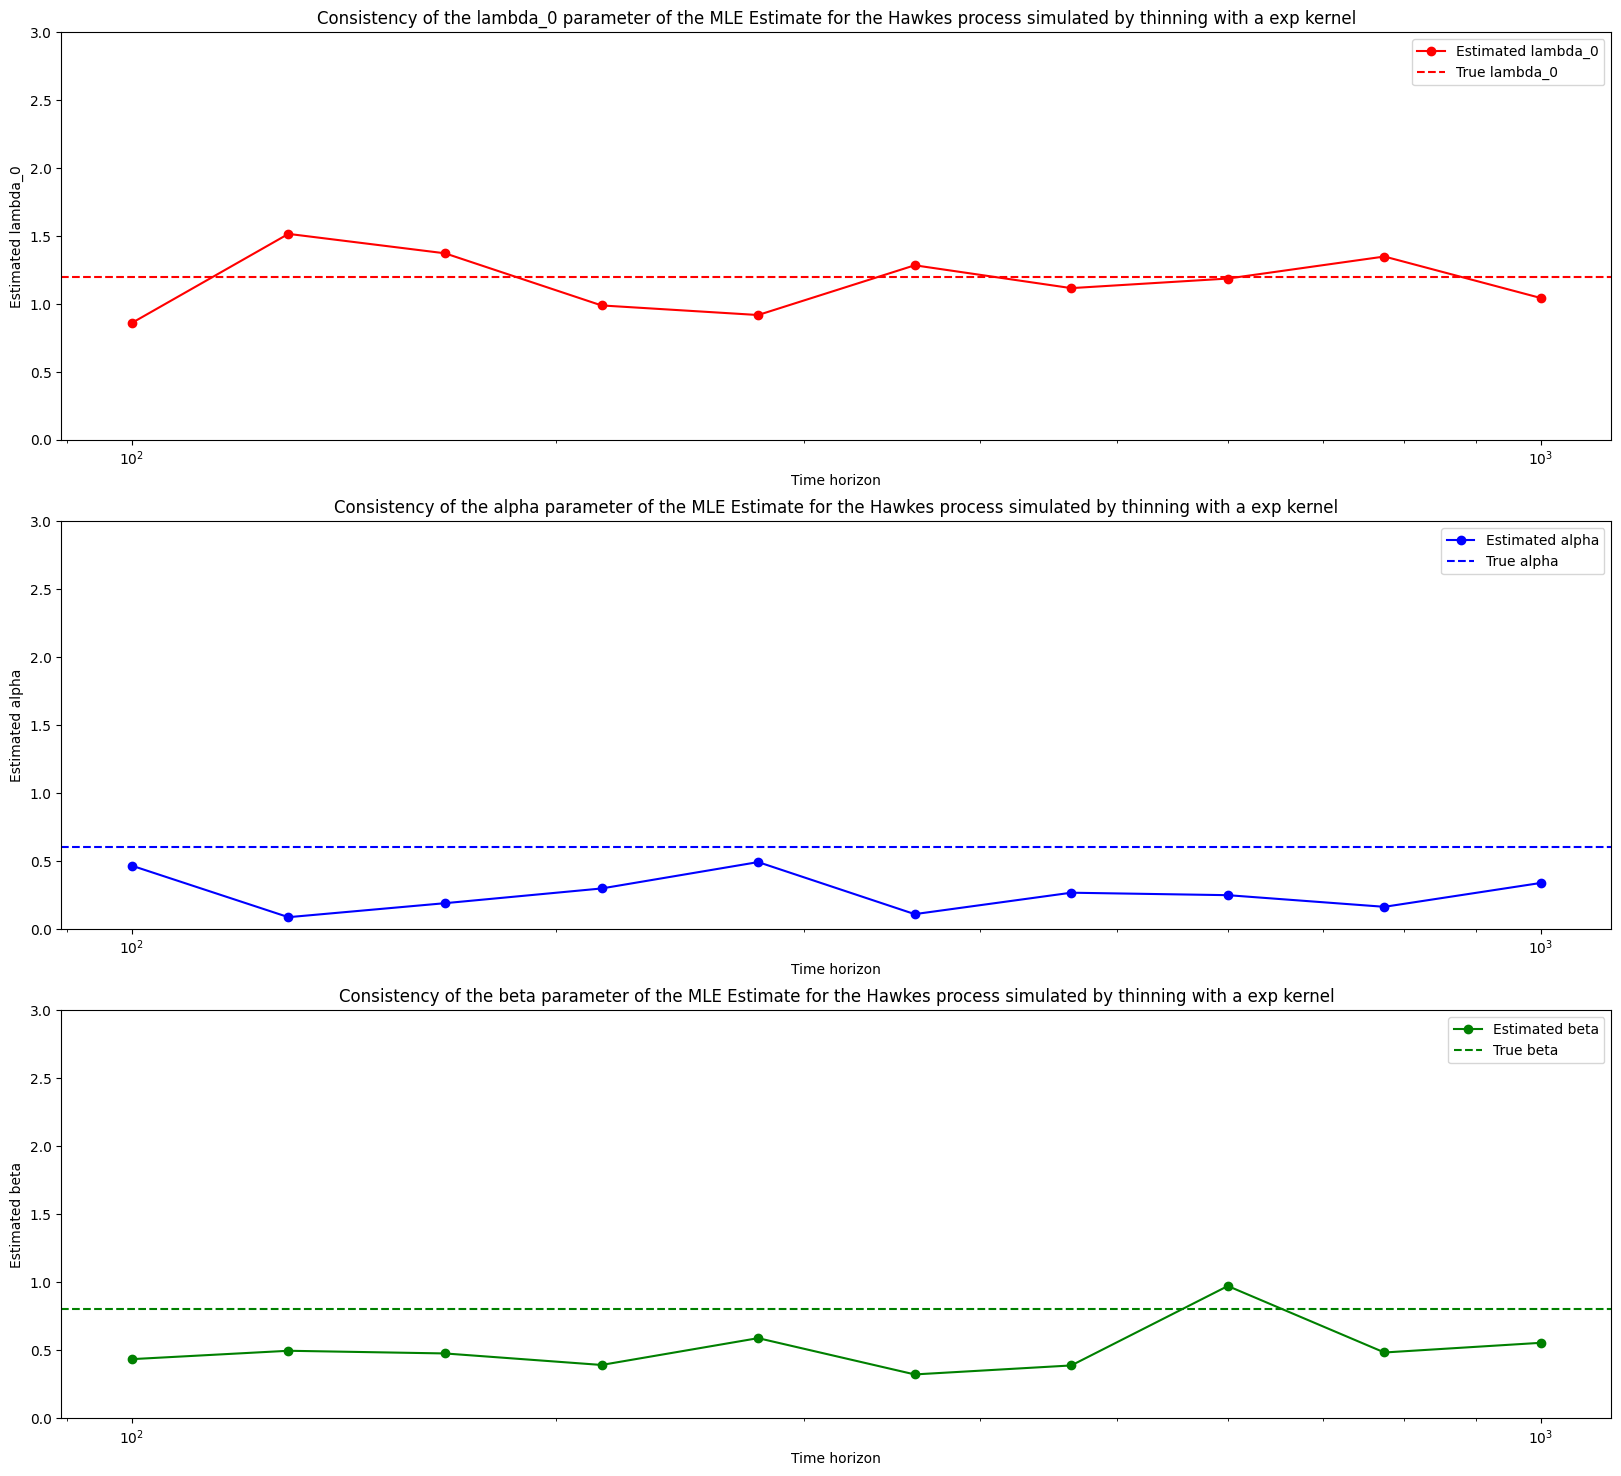

In [42]:
plot_consistency_horizon(true_parameters, T_list, "thinning", exponential_kernel, "exp")

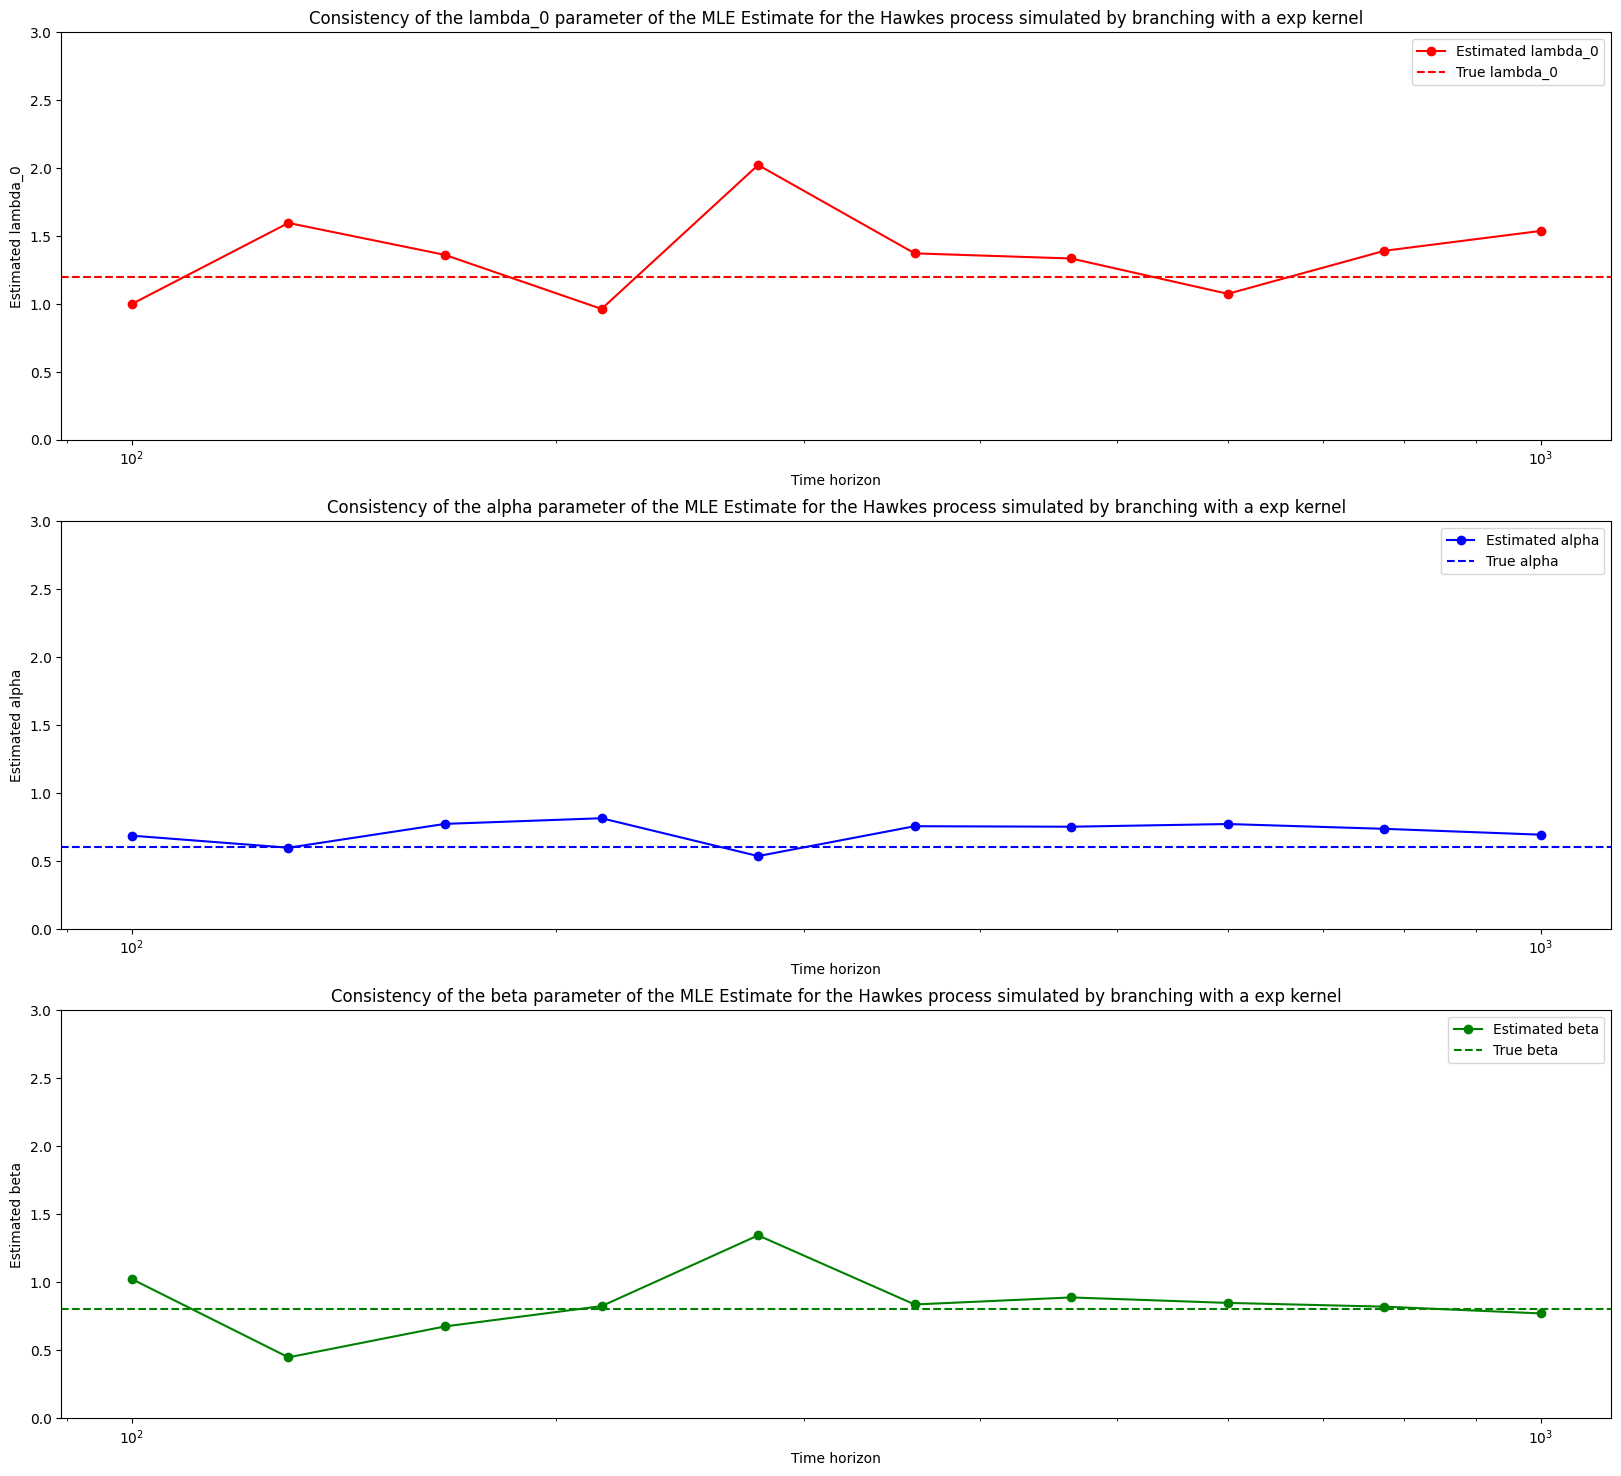

In [43]:
plot_consistency_horizon(true_parameters, T_list, "branching", exponential_kernel, "exp")

Comments : These plots show the consistency of the parameters of the MLE estimates when the time horizon increases. We can see that globally, the convergence of the parameters towards their true value is visible as T increases to $\infty$.

We will try to display the consistency on multiple paths and check the asymptotical efficiency in the meantime (as multiple paths will allow the computation of standard deviations). Doing an average will reduce variability and improve statistical stability. But it will still be possible to observe some fluctuations.

In [60]:
def plot_consistency_horizon_multiple_paths(true_params, T_list, num_paths, algorithm, kernel_func, kernel_name):
    """This function takes six arguments:
    - true_params: the values of the true parameters lambda_0, alpha, beta
    - T_list: the list of time horizons that we will use to observe convergence
    - num_paths: the number of paths simulated with the algorithm
    - algorithm: the name of the algorithm used
    - kernel_func: the kernel function used in the algorithm
    - kernel_name: the name of the kernel used in the MLE_parameters_estimations and also in the title of the plot.
    It plots the evolution of the estimators as a function of the time horizon used in the algorithm."""

    mean_params = {param: [] for param in true_params.keys()}
    std_params = {param: [] for param in true_params.keys()}

    for t in T_list:
        lambda_values = []
        alpha_values = []
        beta_values = []

        for _ in range(num_paths):
            estimation = MLE_parameters_estimations(algorithm, kernel_func, kernel_name, t)
            lambda_values.append(estimation['mu'])
            alpha_values.append(estimation['alpha'])
            beta_values.append(estimation['beta'])

        mean_params['lambda_0'].append(numpy.mean(lambda_values))
        mean_params['alpha'].append(numpy.mean(alpha_values))
        mean_params['beta'].append(numpy.mean(beta_values))
        std_params['lambda_0'].append(numpy.std(lambda_values))
        std_params['alpha'].append(numpy.std(alpha_values))
        std_params['beta'].append(numpy.std(beta_values))

    fig, ax = plt.subplots(4, 1, figsize=(20, 20))
    colors = ['red', 'blue', 'green']

    for i, param in enumerate(true_params.keys()):
        ax[i].plot(T_list, mean_params[param], label=f'Estimated {param}', color=colors[i], marker='o')
        ax[i].axhline(true_params[param], color=colors[i], linestyle='--', label=f'True {param}')
        ax[i].set_title(f'Consistency of the {param} of the MLE Estimate for the Hawkes process simulated by {algorithm} with a {kernel_name} kernel and {num_paths} paths')
        ax[i].set_xlabel("Time horizon")
        ax[i].set_ylim([0, 3])
        ax[i].set_ylabel(f'Estimated {param}')
        ax[i].legend()
    for i, param in enumerate(true_params.keys()):
        log_T = numpy.log(T_list[6:])
        log_std = numpy.log(std_params[param][6:])
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(log_T, log_std)
        ax[3].plot(T_list, std_params[param], label=f'Std {param} in power {slope:.3f}', color=colors[i], marker='o')
    ax[3].plot(T_list, [1/numpy.sqrt(t) for t in T_list], 
        label='1/sqrt(T)', color='black', linestyle='--')
    ax[3].set_title(f'Standard error of the estimation of the MLE for the Hawkes process simulated by {algorithm} with a {kernel_name} kernel and {num_paths} paths')
    ax[3].set_xlabel("Time horizon")
    ax[3].set_xscale('log')
    ax[3].set_ylabel("Standard error")
    ax[3].set_yscale('log')
    ax[3].legend()
    plt.show()

100%|██████████| 10/10 [05:41<00:00, 34.11s/it]


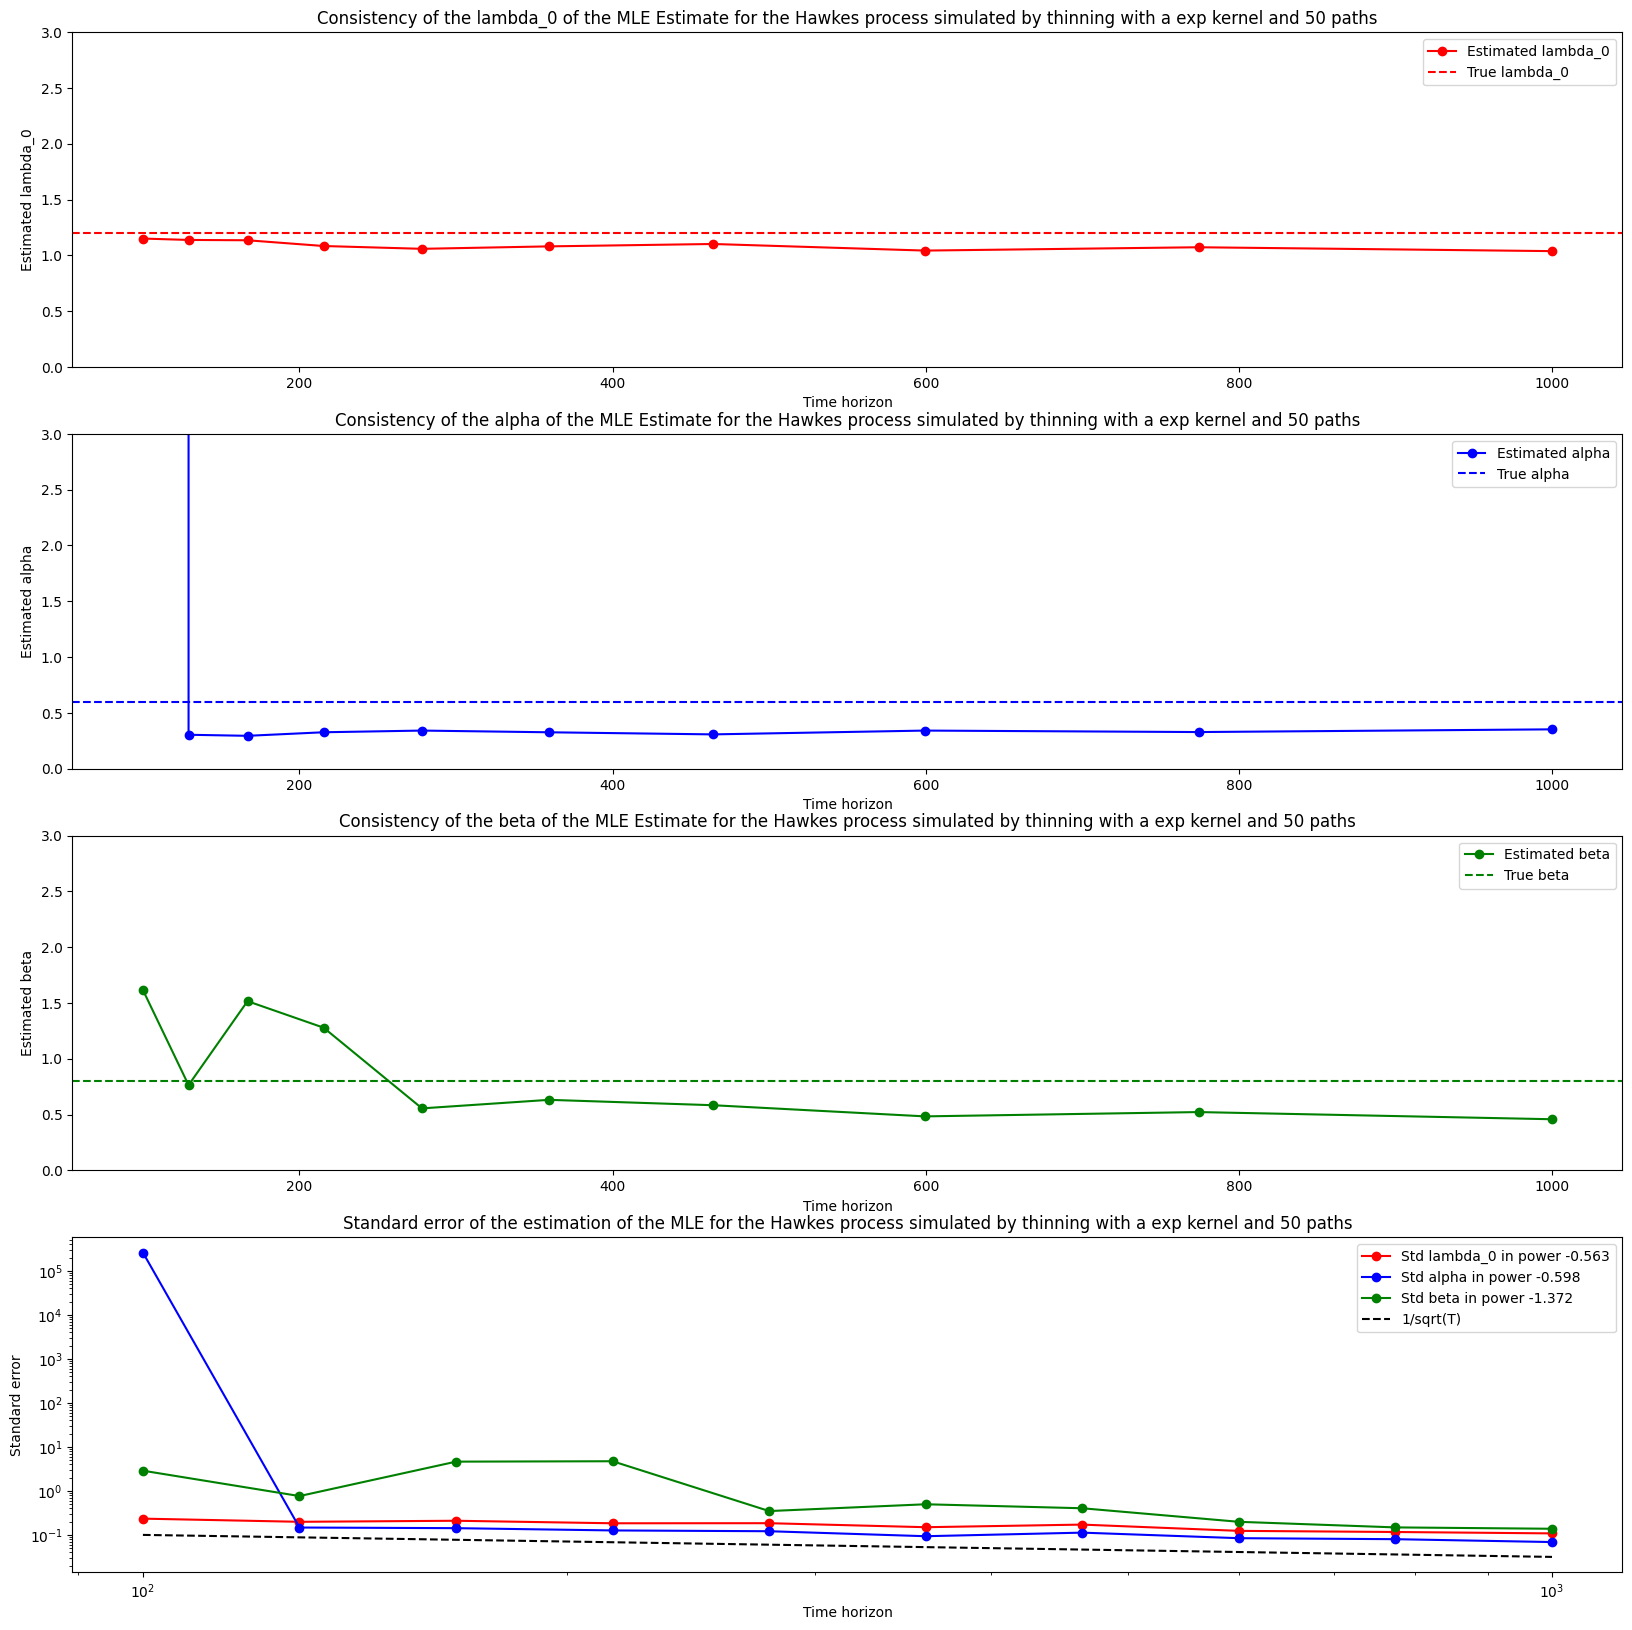

In [62]:
T_list = numpy.logspace(2, 3, 10)
num_paths = 50
plot_consistency_horizon_multiple_paths(true_parameters, T_list, num_paths, "thinning", exponential_kernel, "exp")

100%|██████████| 10/10 [29:30<00:00, 177.09s/it]


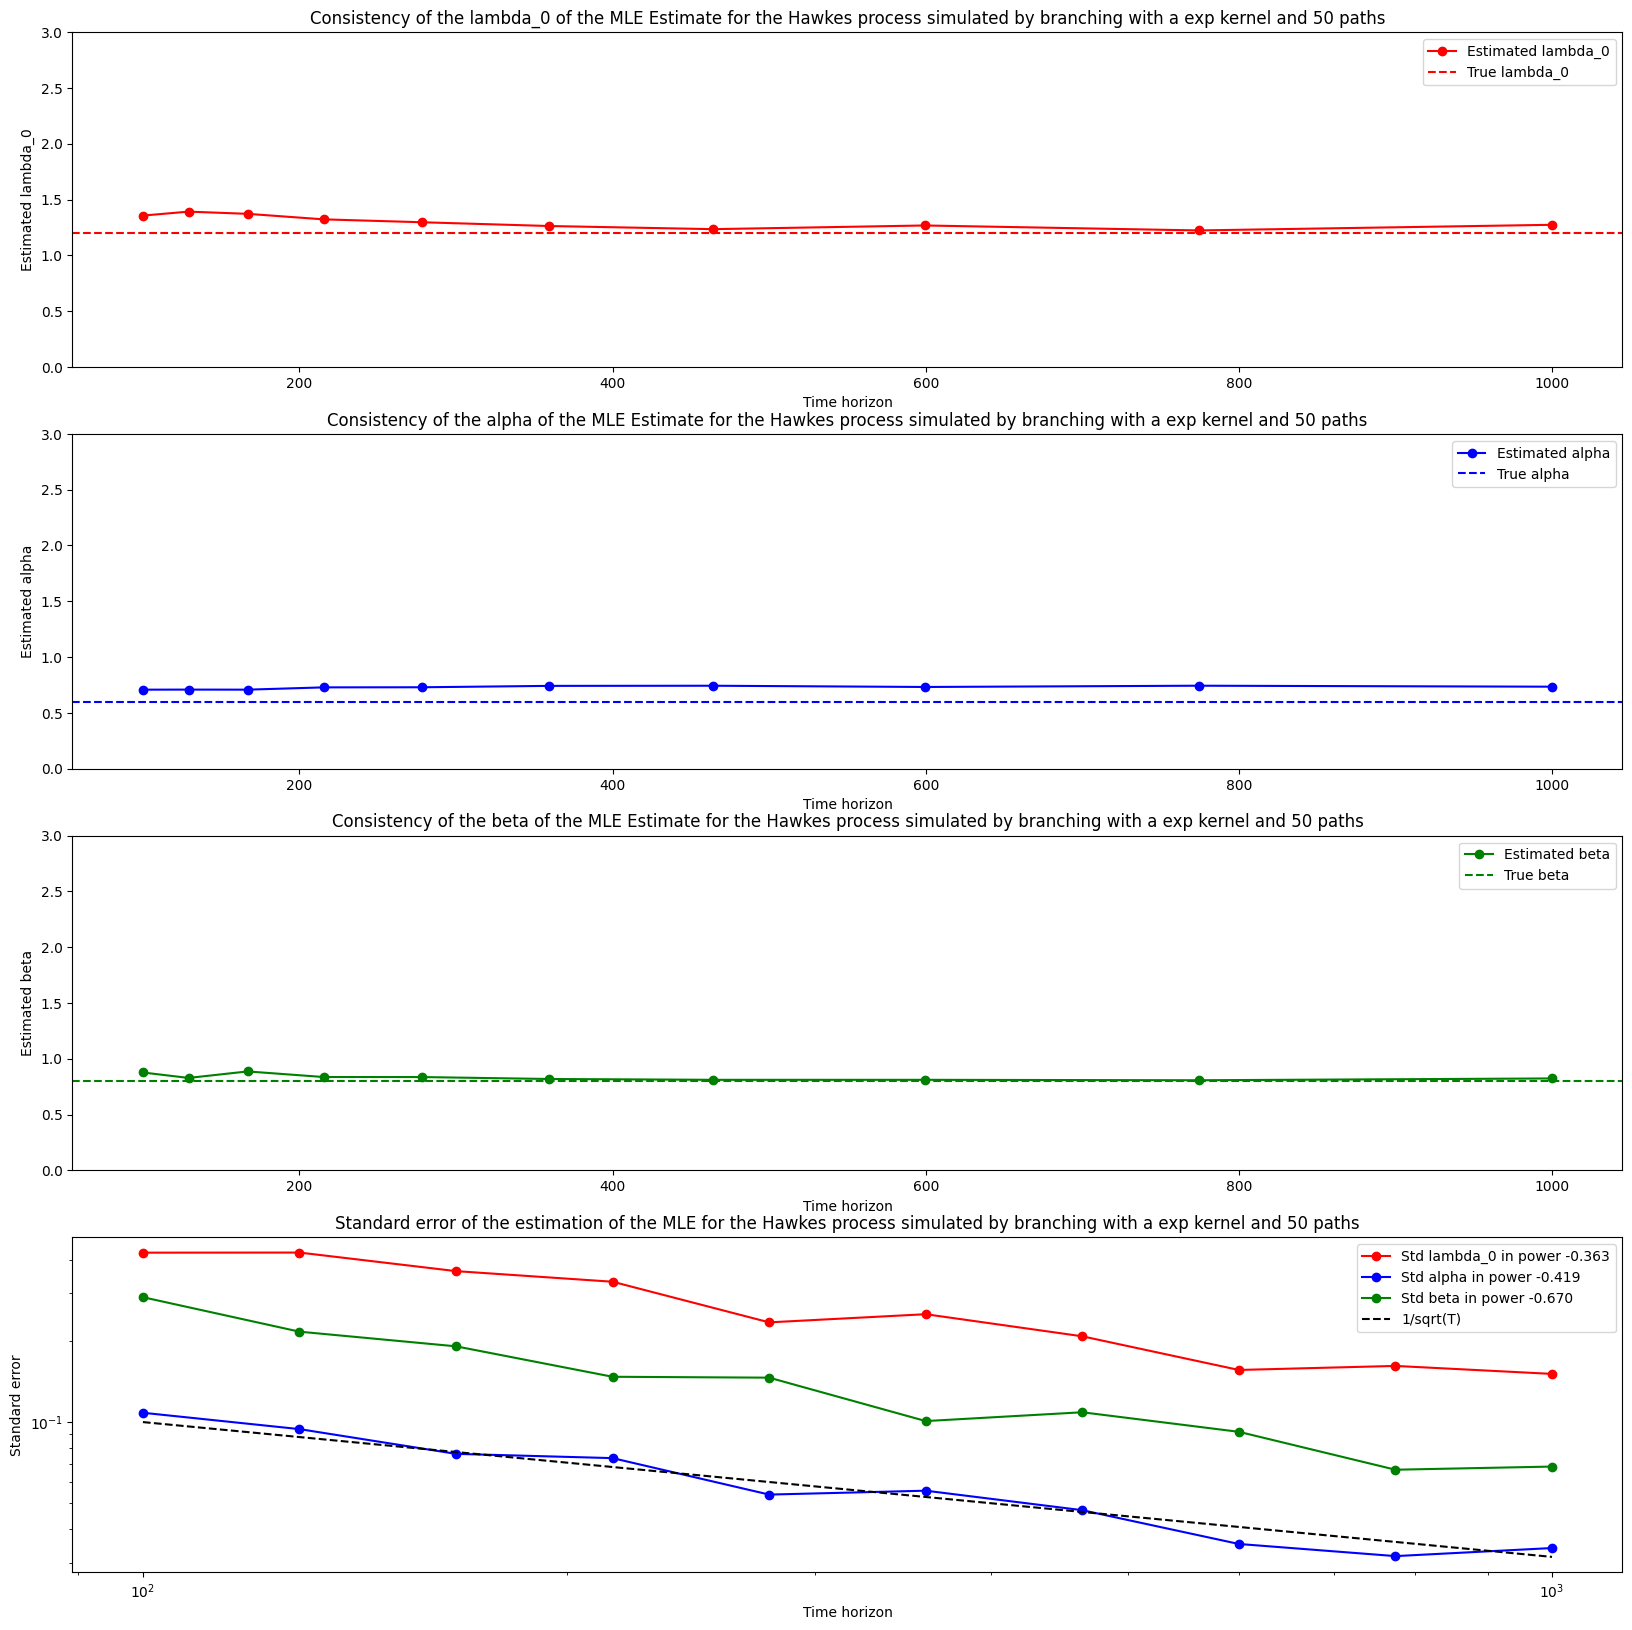

In [63]:
plot_consistency_horizon_multiple_paths(true_parameters, T_list, num_paths, "branching", exponential_kernel, "exp")

Comments : Therefore, by displaying the consistency on multiple paths, we can conclude that the pattern seen on the one path simulation consistency is still valid : the branching algorithm is better in terms of convergence than the thinning algorithm. Indeed, the branching algorithm, on the contrary has a more structured approach and models the event dependencies more explicitely, ensuring a better convergence.

We added a standard deviation plot in order to visualize the convergence of the three parameters and check the asymptotical efficiency property : the standard deviation decreases in almost $O(T^{-0.2})/O(T^{-0.3})$ for the thinning algorithm and a bit faster for the branching one. The exponent is calculated for the last points of the time array, therefore for the biggest time horizons. This decrease means that the variance is decreasing in $O(T^{-0.4})/O(T^{-0.5})$. For it to be considered asymptotical efficient, it should have decreased in $O(\frac{1}{T})$ but the few points used increases variability and maybe overestimated it. Increasing num_paths should stabilize the plots but it is really taking too much time. Formally, the estimators would need to asymptotically reach the lower bound of the variance of an estimate, which is the Cramer-Rao lower bound. But the computation of the Cramer-Rao bound requires the Fisher Information matrix derivated from the expression of the likelihood. Here, we  only checked that the variance decrease and asymptotically at a rate of $O(\frac{1}{\sqrt{T}})$.

Now, we are going to study the asymptotic normality property that the MLE estimator is supposed to follow.

In [71]:
def plot_asymptotic_normality(true_params, T_list, num_paths, algorithm, kernel_func, kernel_name):
    """This function takes six arguments :
    - true_params : the values of the true parameters lambda_0, alpha, beta
    - T_list : the list of time horizons that we will use to observe to convergence
    - num_paths : the number of paths simulated with the algorithm
    - algorithm : the name of the algorithm used
    - kernel_func : the kernel function used in the algorithm
    - kernel_name : the name of the kernel used in the MLE_parameters_estimations and also in the title of the plot.
    It plots the distribution of the estimators of the parameters for each time horizon used in the algorithm, and the QQ-plot between our empirical data and the theoretical normal distribution."""
    # We create a dictionary that associates the multiple estimations (due to num_paths) of the parameters with the time horizon used, to make the plot easier.
    estimations = {t: [MLE_parameters_estimations(algorithm, kernel_func, 
                                                  kernel_name, t) for _ in 
                       range(num_paths)] for t in T_list}
    # We update the name of the parameter 'mu' and replace it by 'lambda_0'.
    for t in estimations:
      for i, estimation in enumerate(estimations[t]):
          ordered_estimation = {
              'lambda_0': estimation.pop('mu'),
              'alpha': estimation['alpha'],
              'beta': estimation['beta']
          }
          estimations[t][i] = ordered_estimation
    for t, estimates in estimations.items():
      num_params = len(true_params)
      fig, axes = plt.subplots(nrows=num_params, ncols=2, figsize=(14, 6*num_params))

      if num_params == 1:
          axes = numpy.array([axes])

      colors = ["red", "blue", "green"]

      for i, param in enumerate(true_params.keys()):
          param_list = [est[param] for est in estimates]
          mean = numpy.mean(param_list)
          std = numpy.std(param_list)

          ax_hist = axes[i, 0]
          ax_norm = ax_hist.twinx()
          ax_hist.hist(param_list, bins=50, alpha=0.6, color=colors[i % len(colors)],
                      label='MLE Estimates', density=True)

          x = numpy.linspace(min(param_list), max(param_list), 1000)
          ax_norm.plot(x, scipy.stats.norm.pdf(x, mean, std), label='Normal Distribution',
                      color='black')

          ax_hist.set_title(f'Distribution of {param} Estimates (t={t:.1f}) for the {algorithm} algorithm')
          ax_hist.set_xlabel(param)
          ax_hist.set_ylabel('Density')
          ax_norm.set_ylabel('Normal Density')

          lines_hist, labels_hist = ax_hist.get_legend_handles_labels()
          lines_norm, labels_norm = ax_norm.get_legend_handles_labels()
          ax_hist.legend(lines_hist + lines_norm, labels_hist + labels_norm, loc='upper left')

          ax_qq = axes[i, 1]
          scipy.stats.probplot(param_list, dist="norm", sparams=(mean, std), plot=ax_qq)
          ax_qq.set_title(f'QQ-Plot of {param} Estimates (t={t:.1f}) for the {algorithm} algorithm')
          ax_qq.set_xlabel('Theoretical Quantiles')
          ax_qq.set_ylabel('Ordered Values')

      plt.tight_layout()
      plt.show()

100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


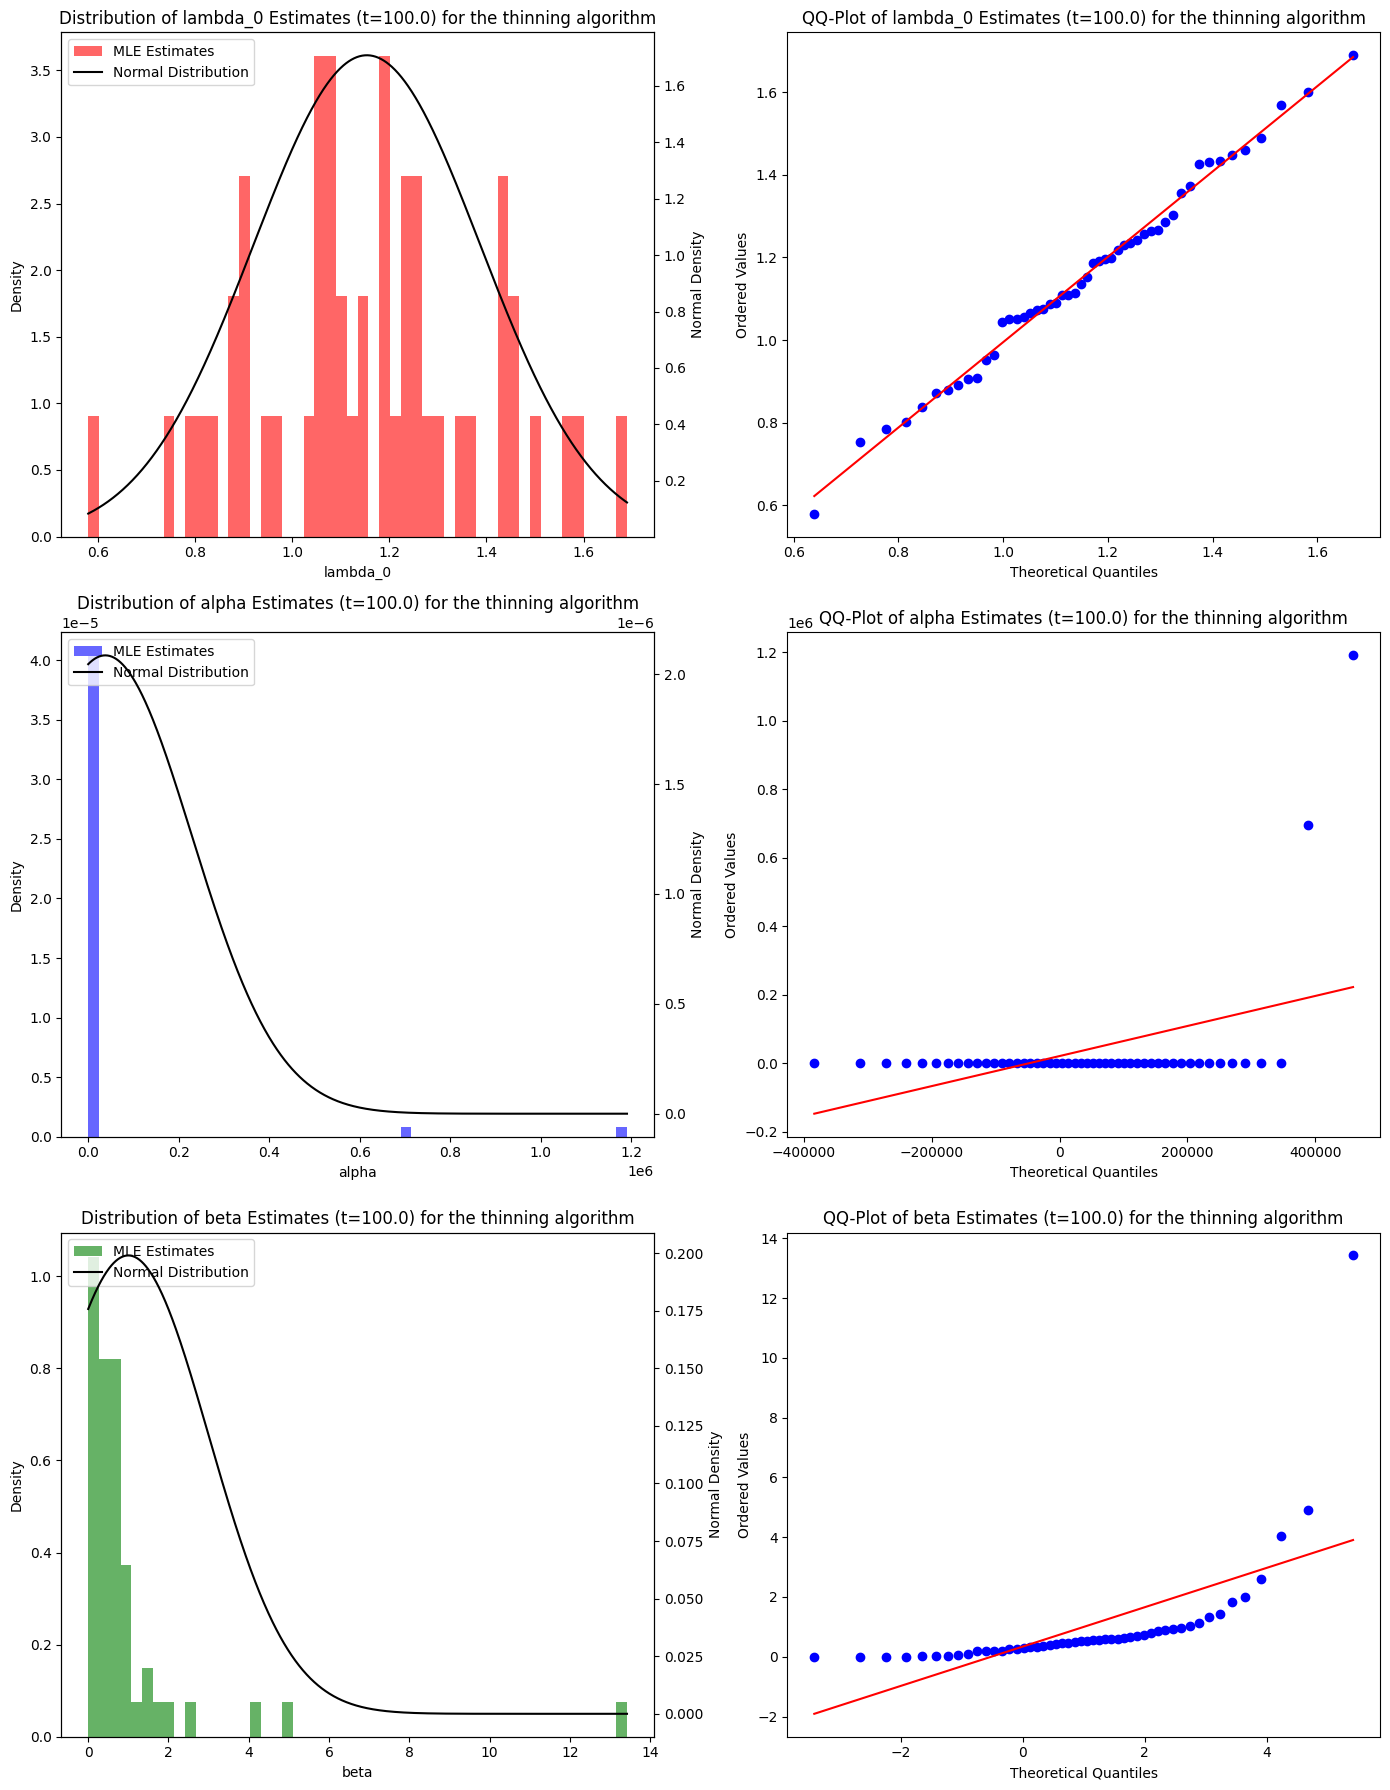

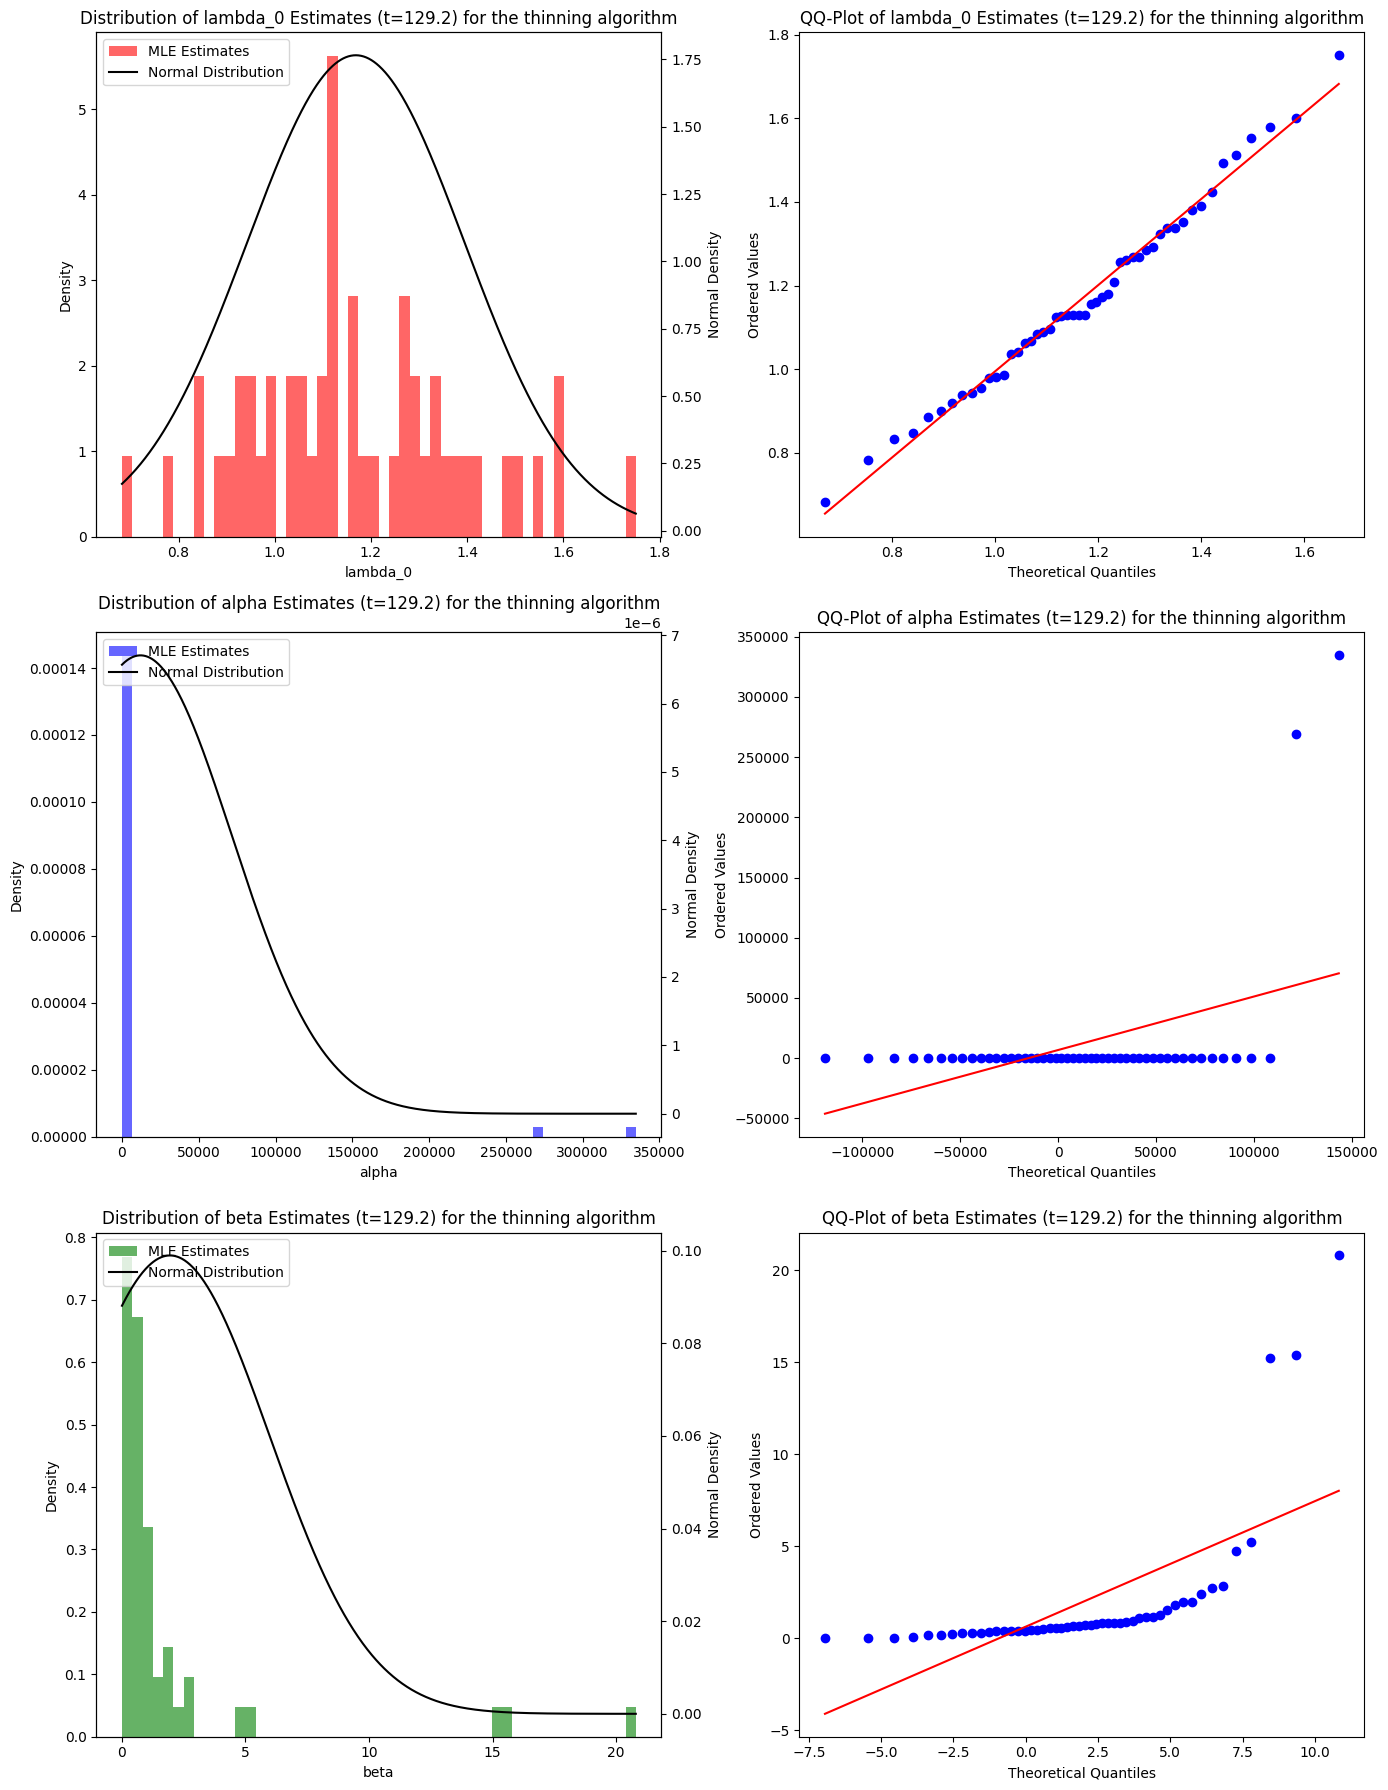

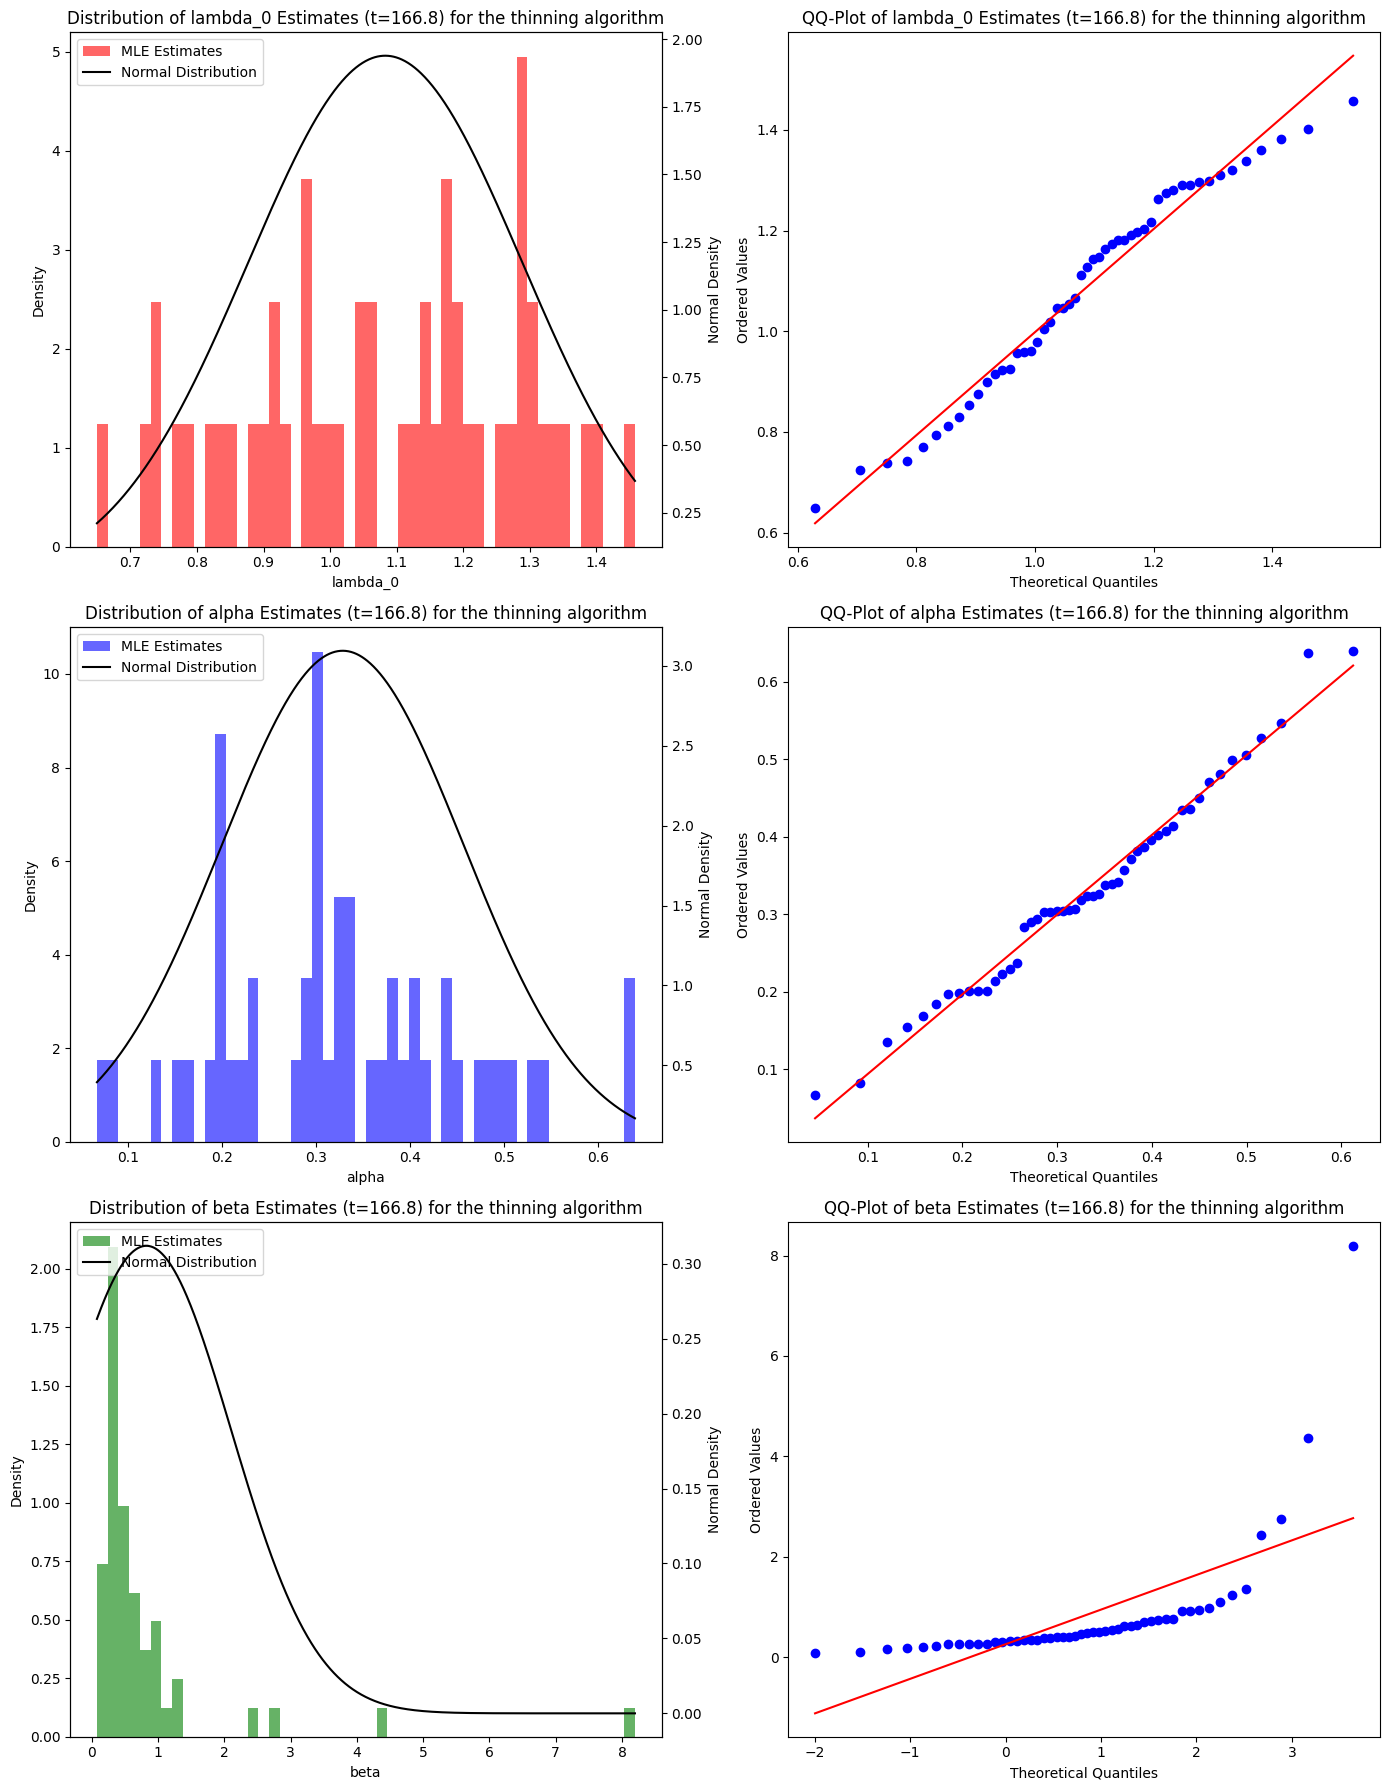

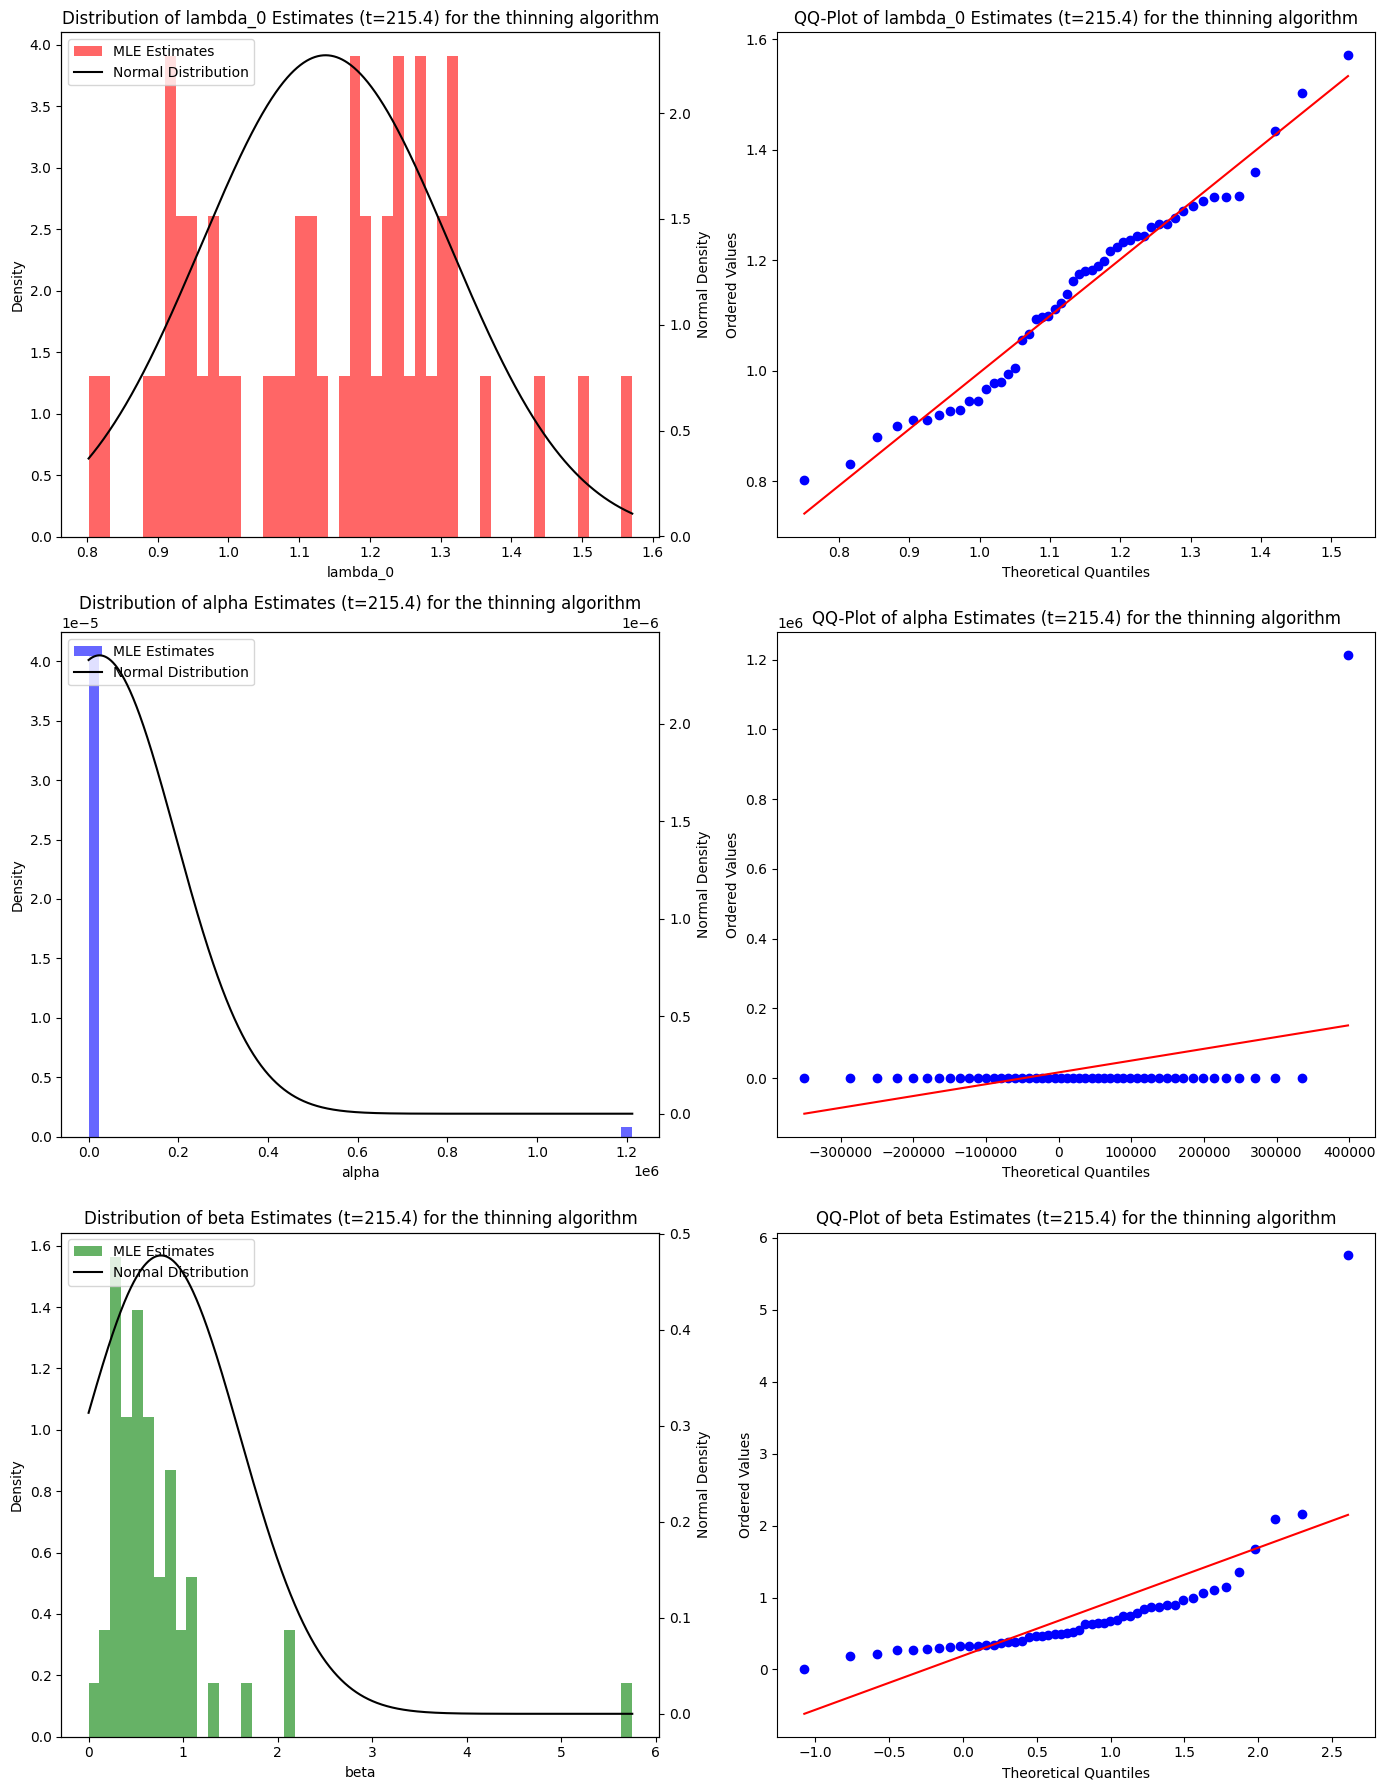

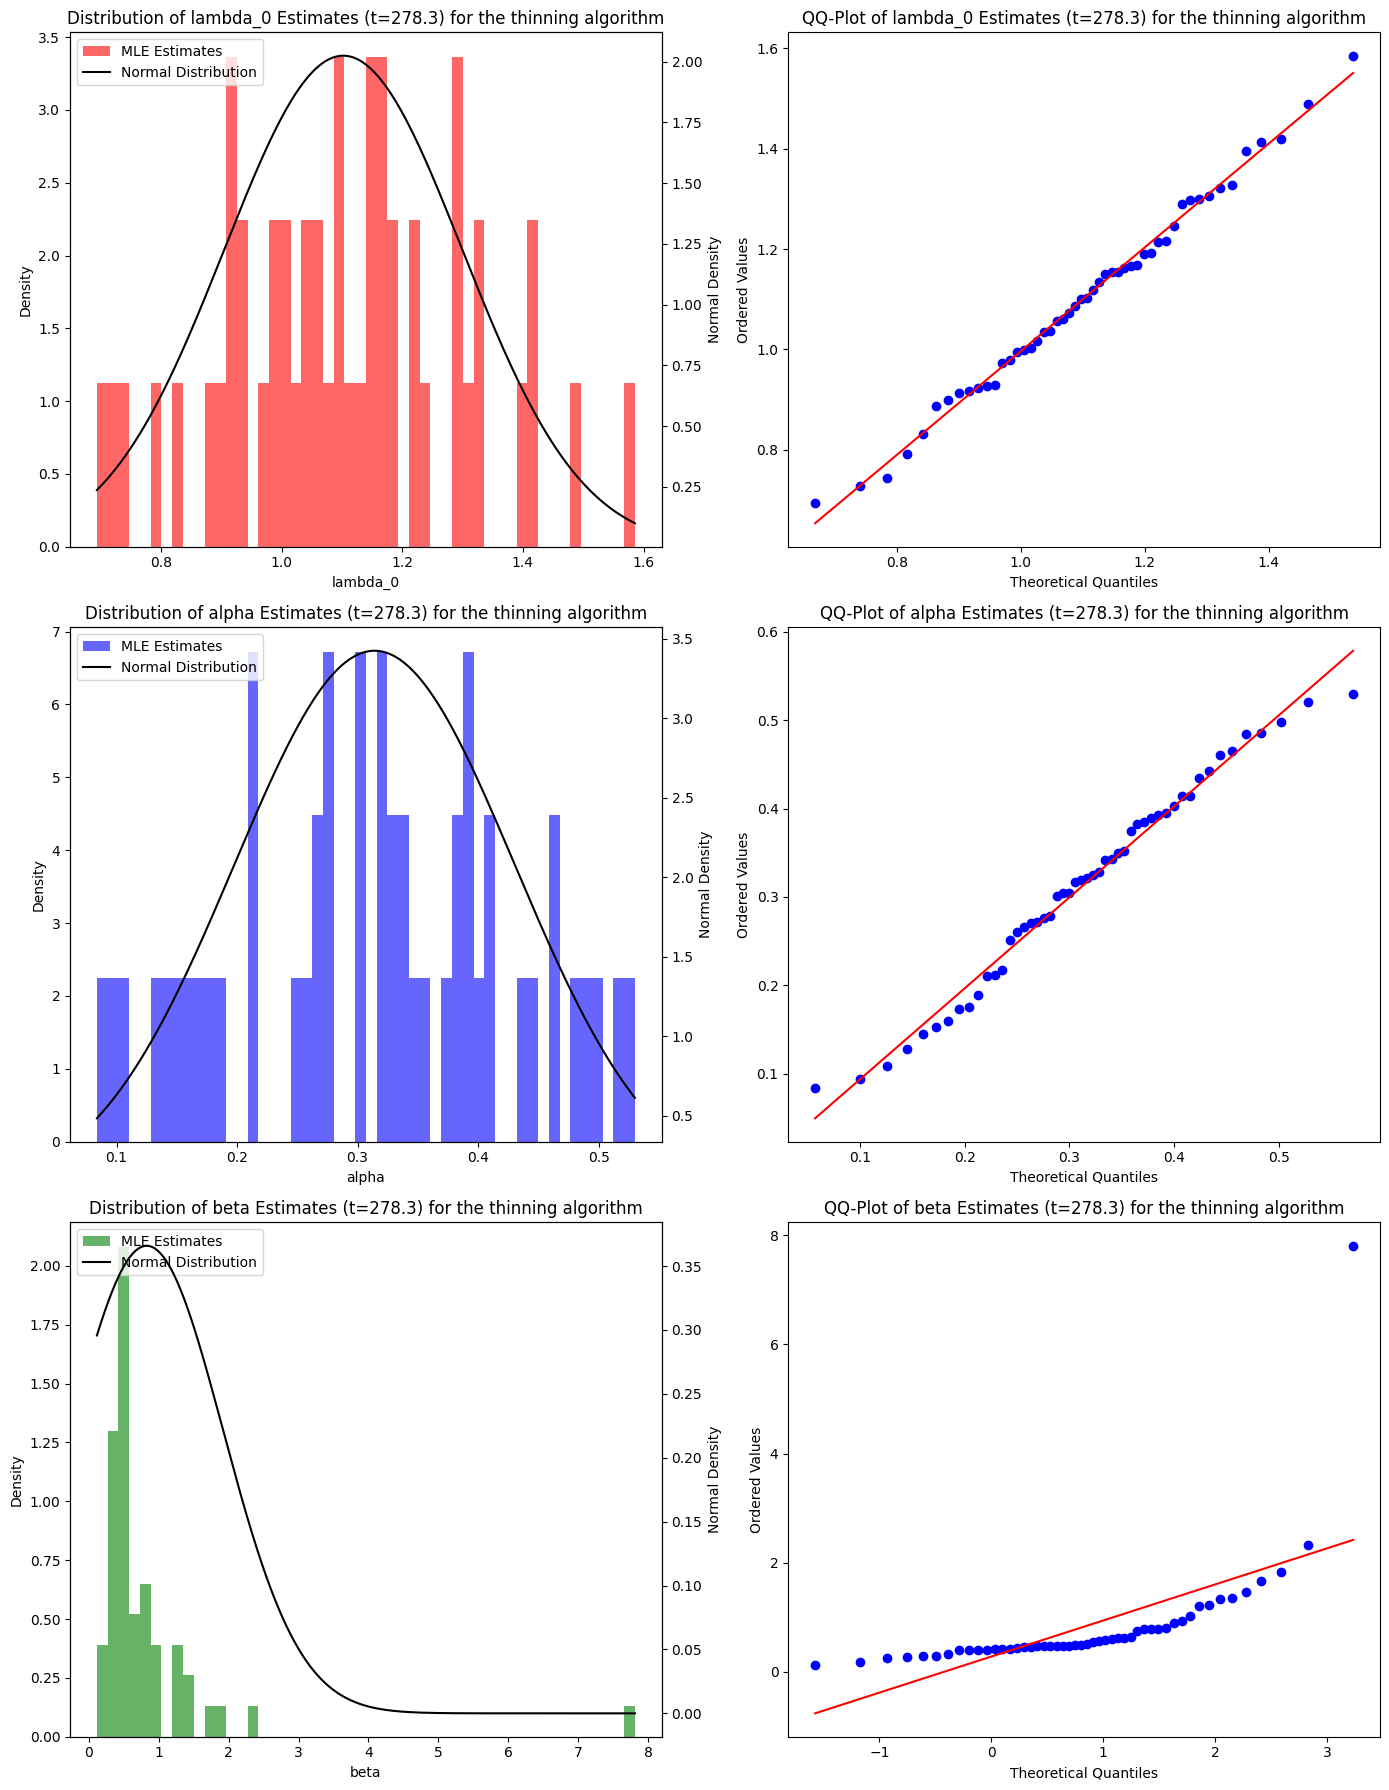

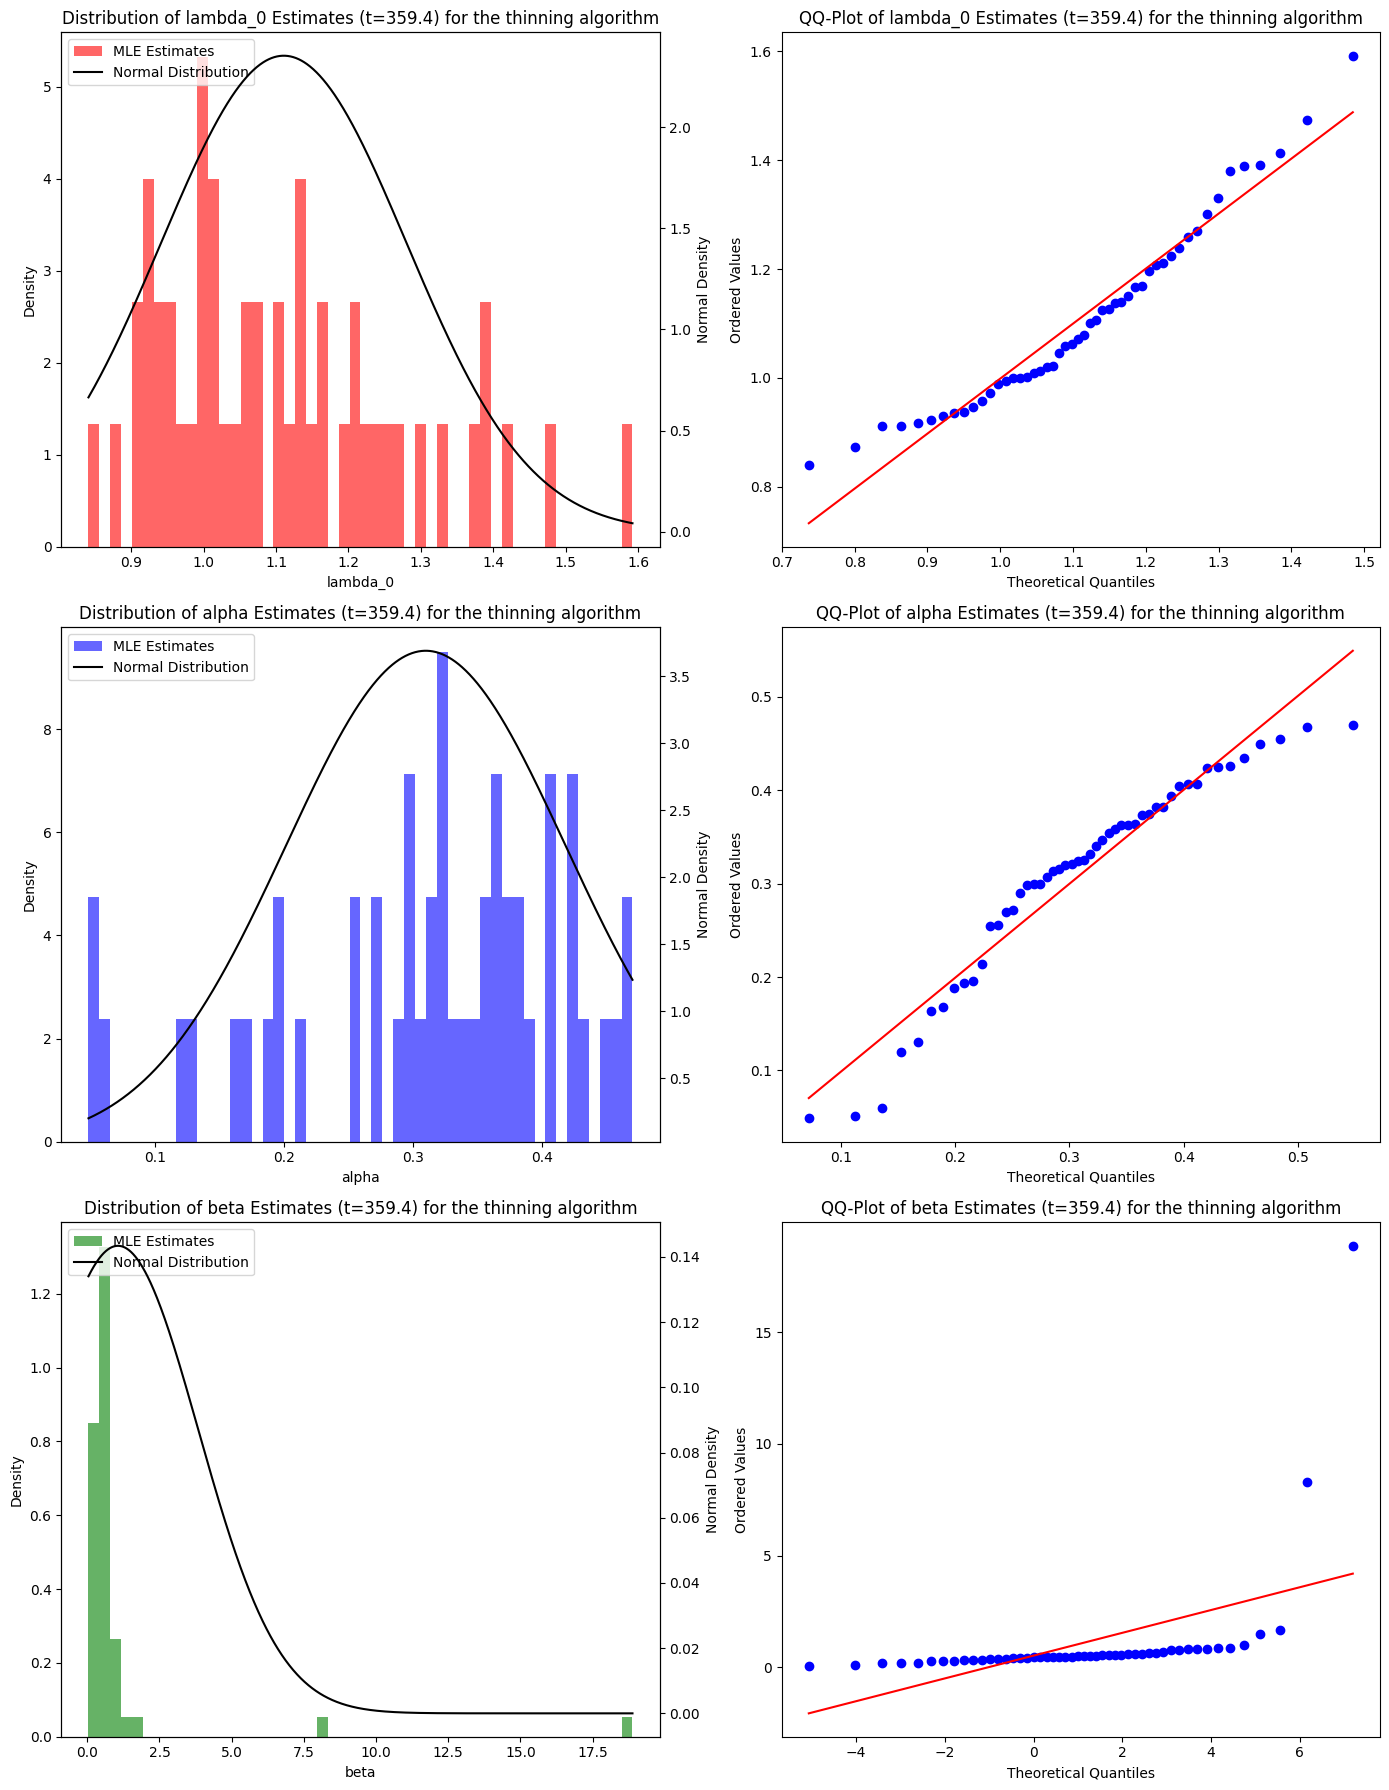

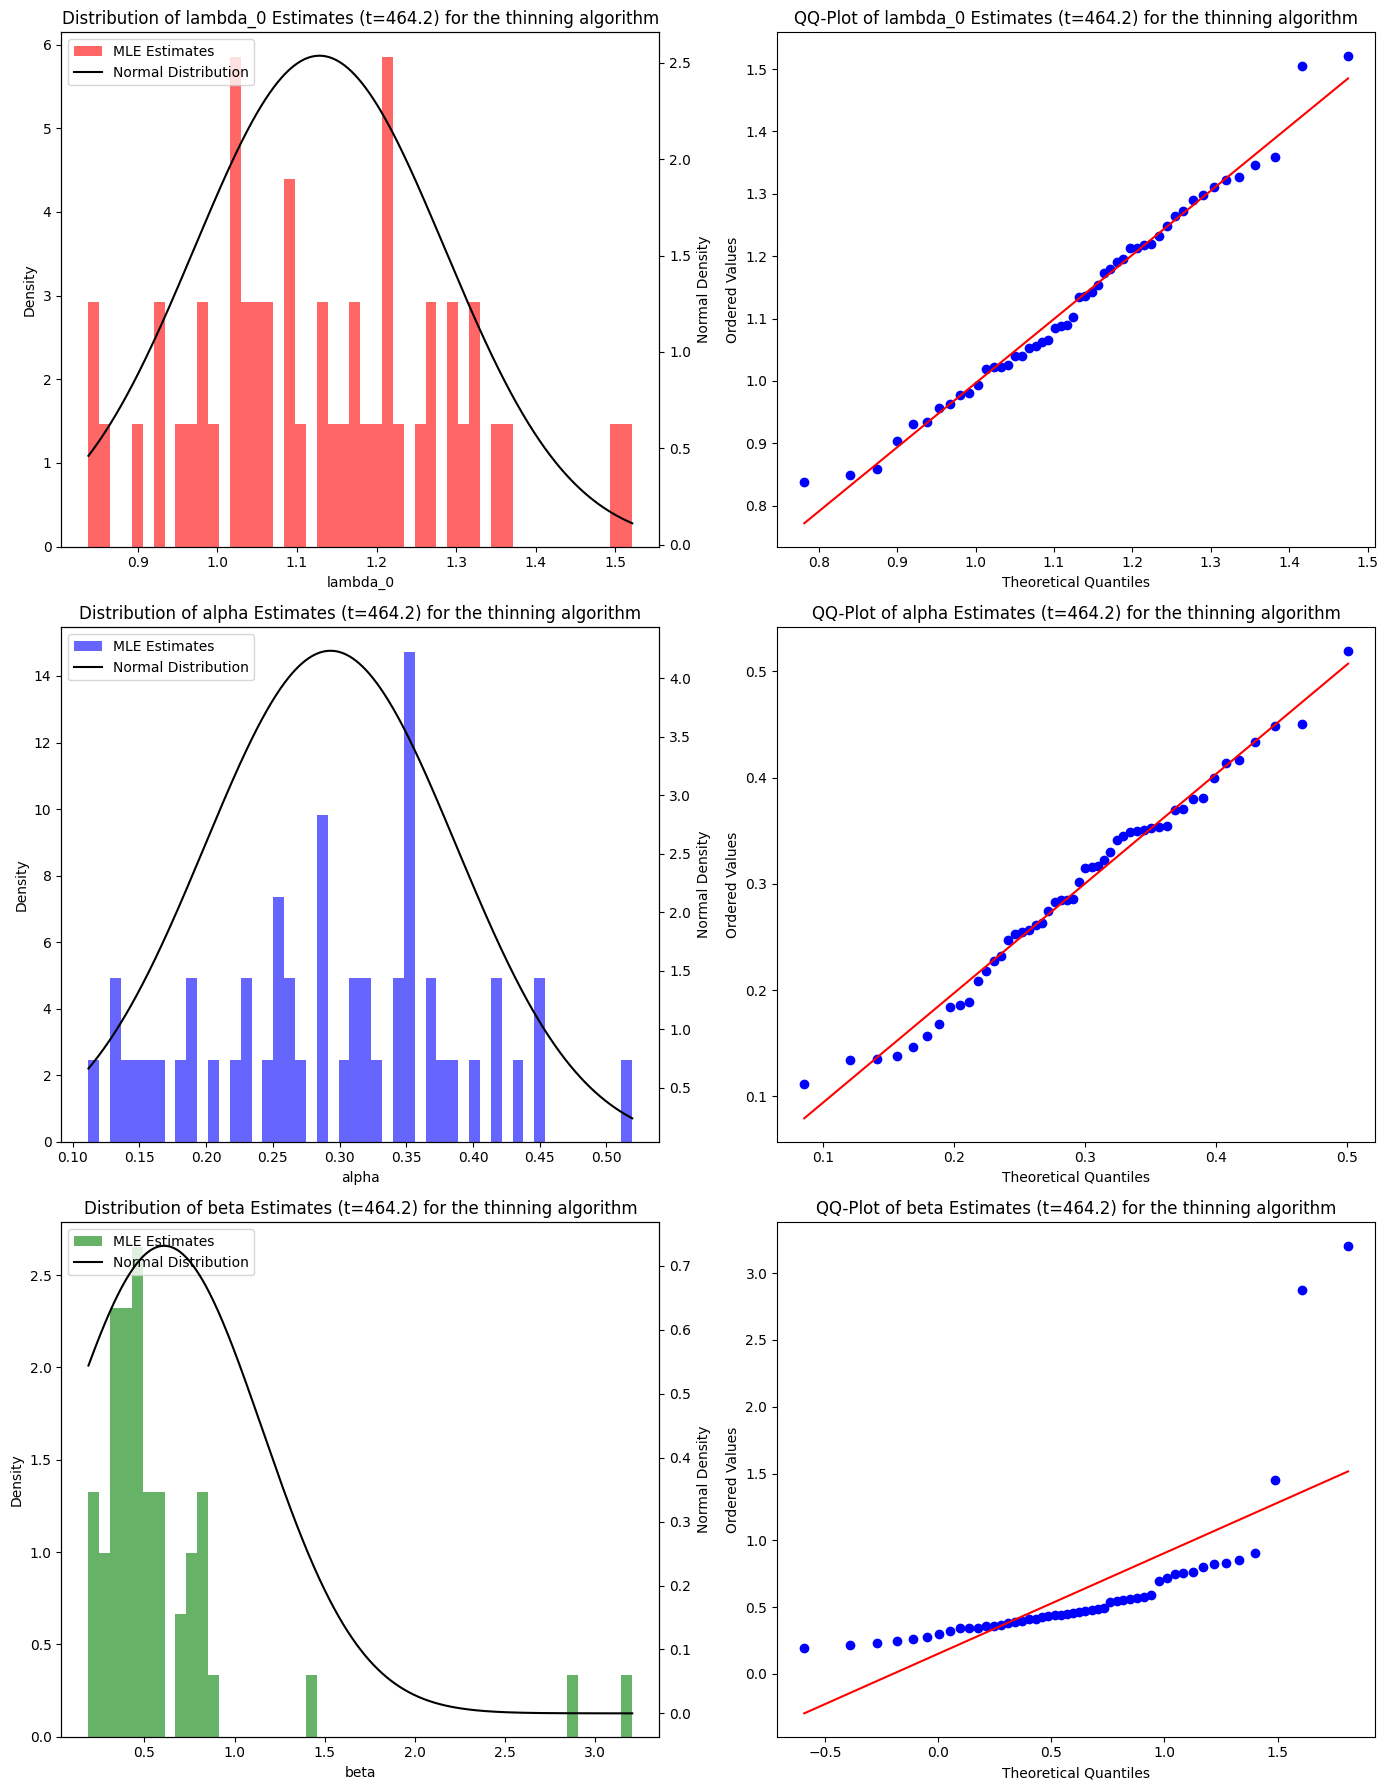

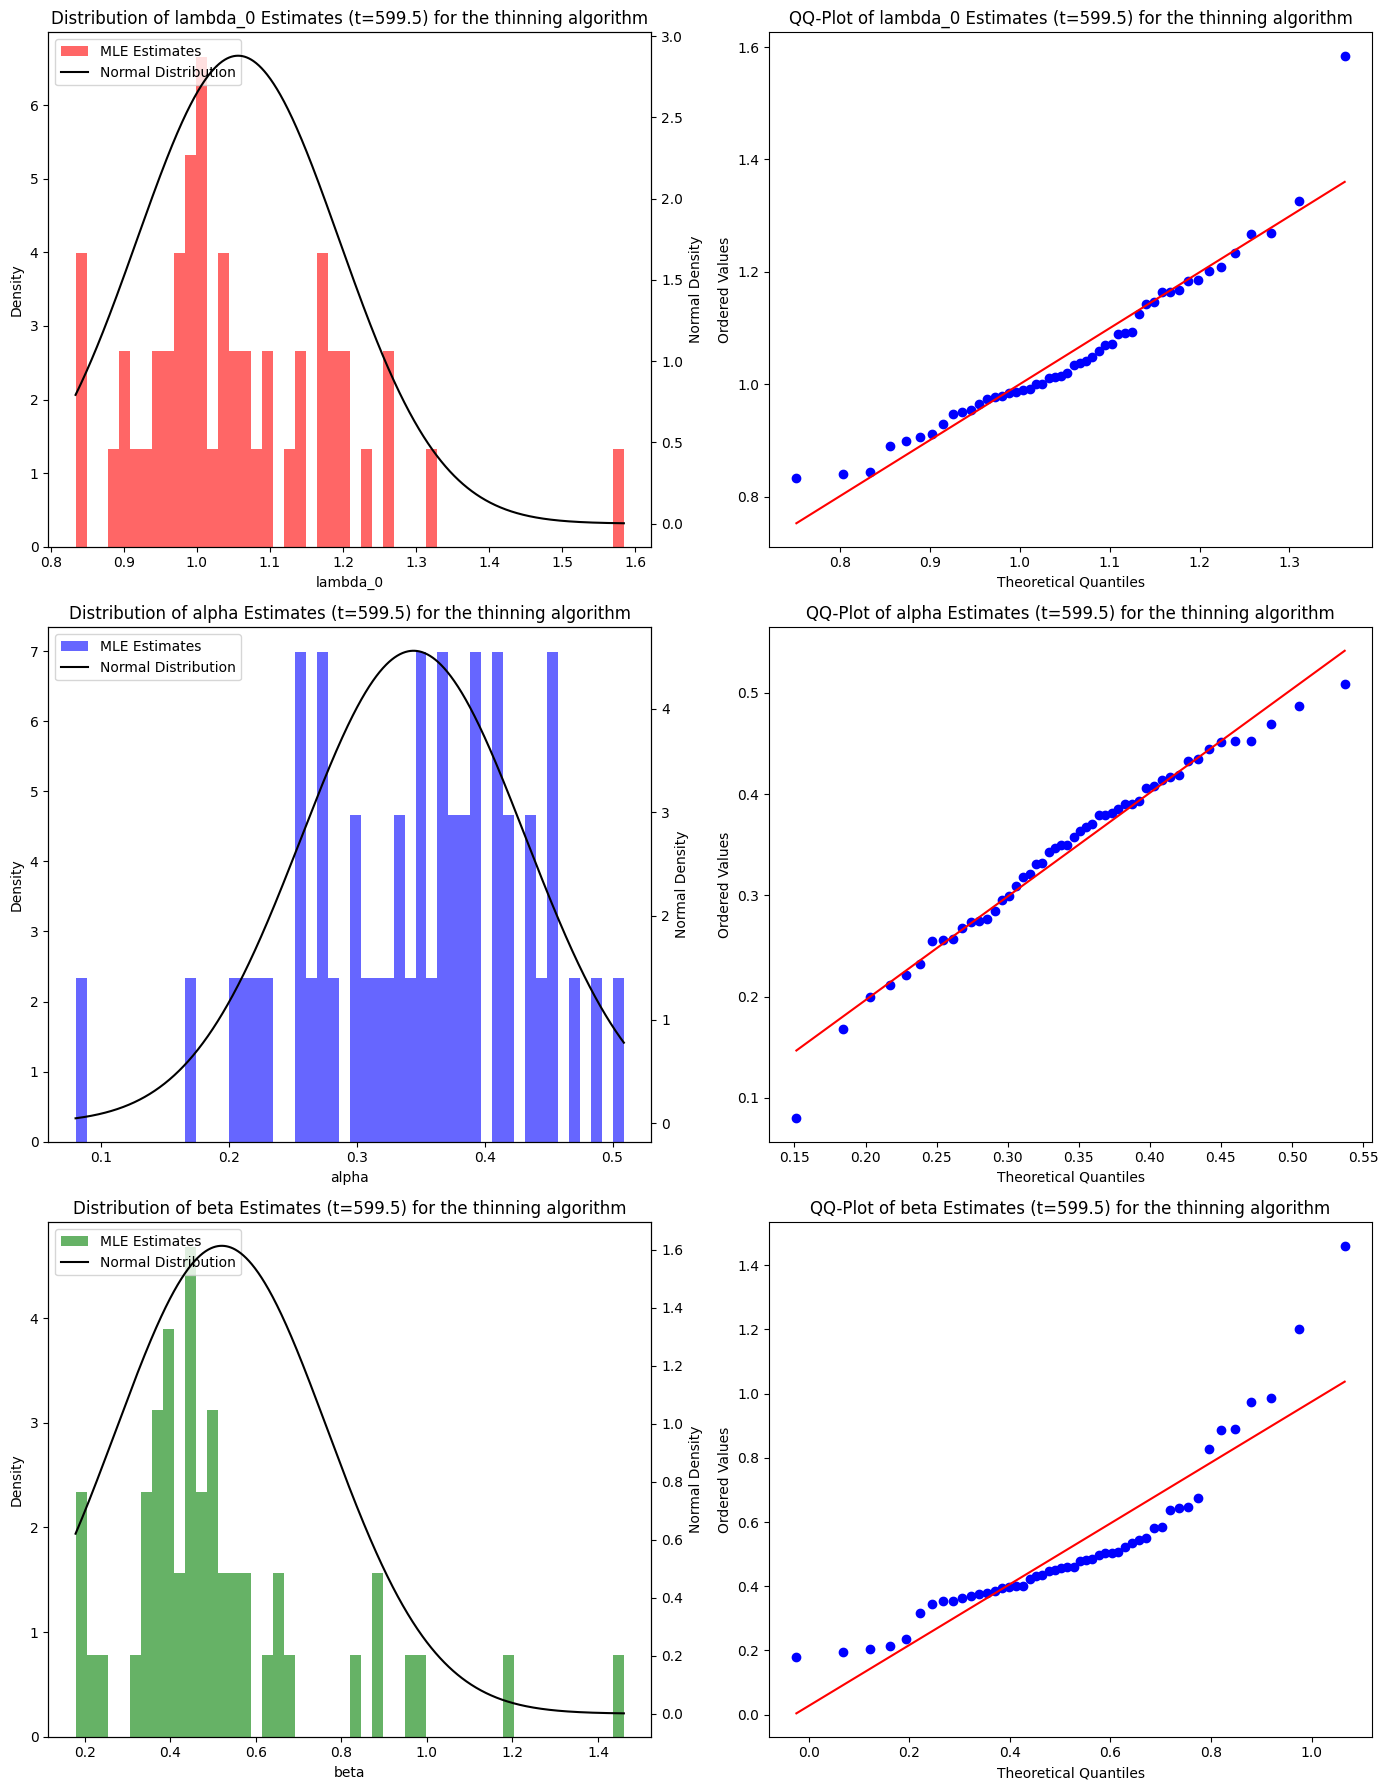

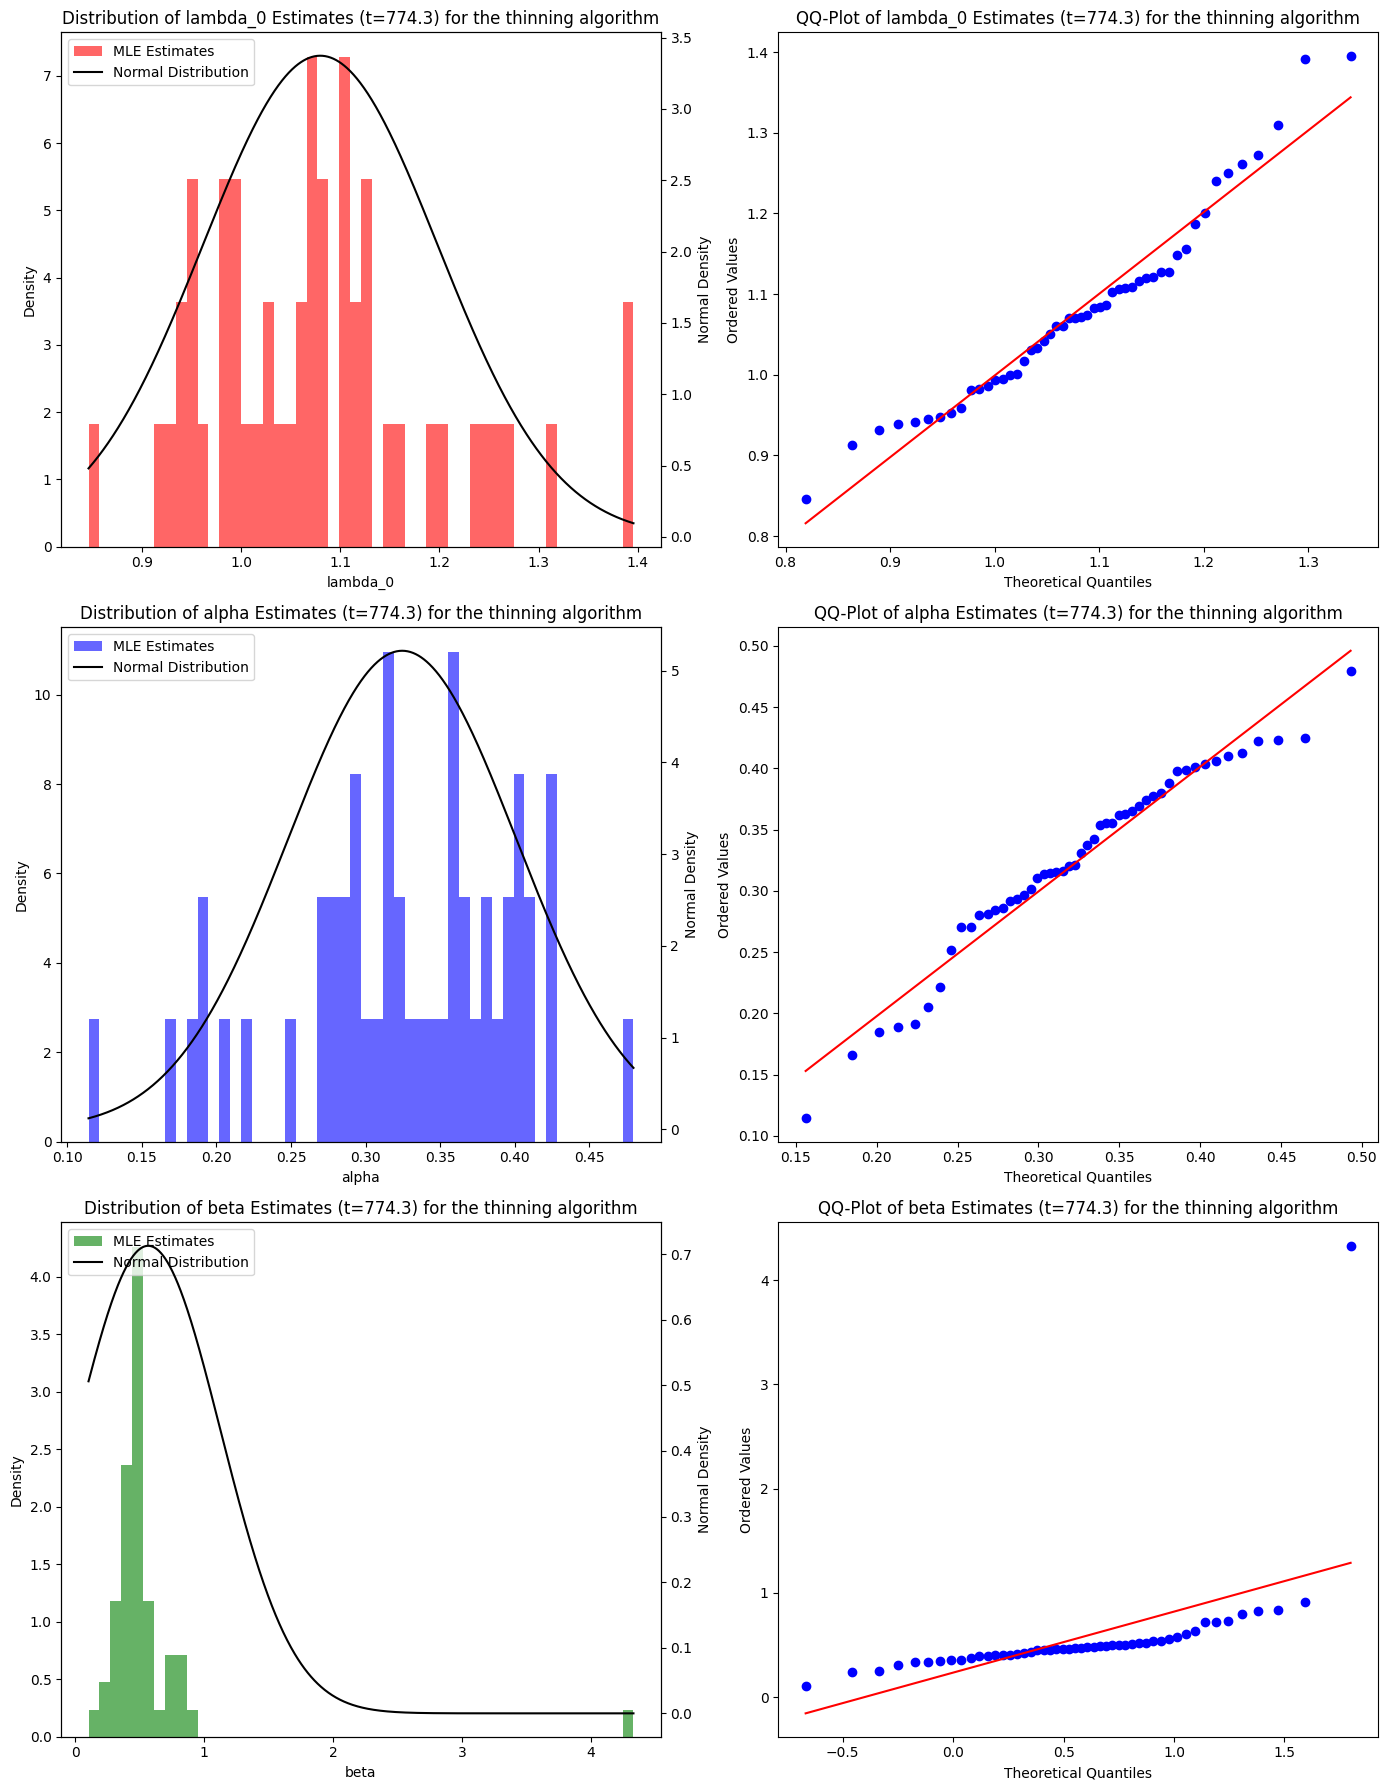

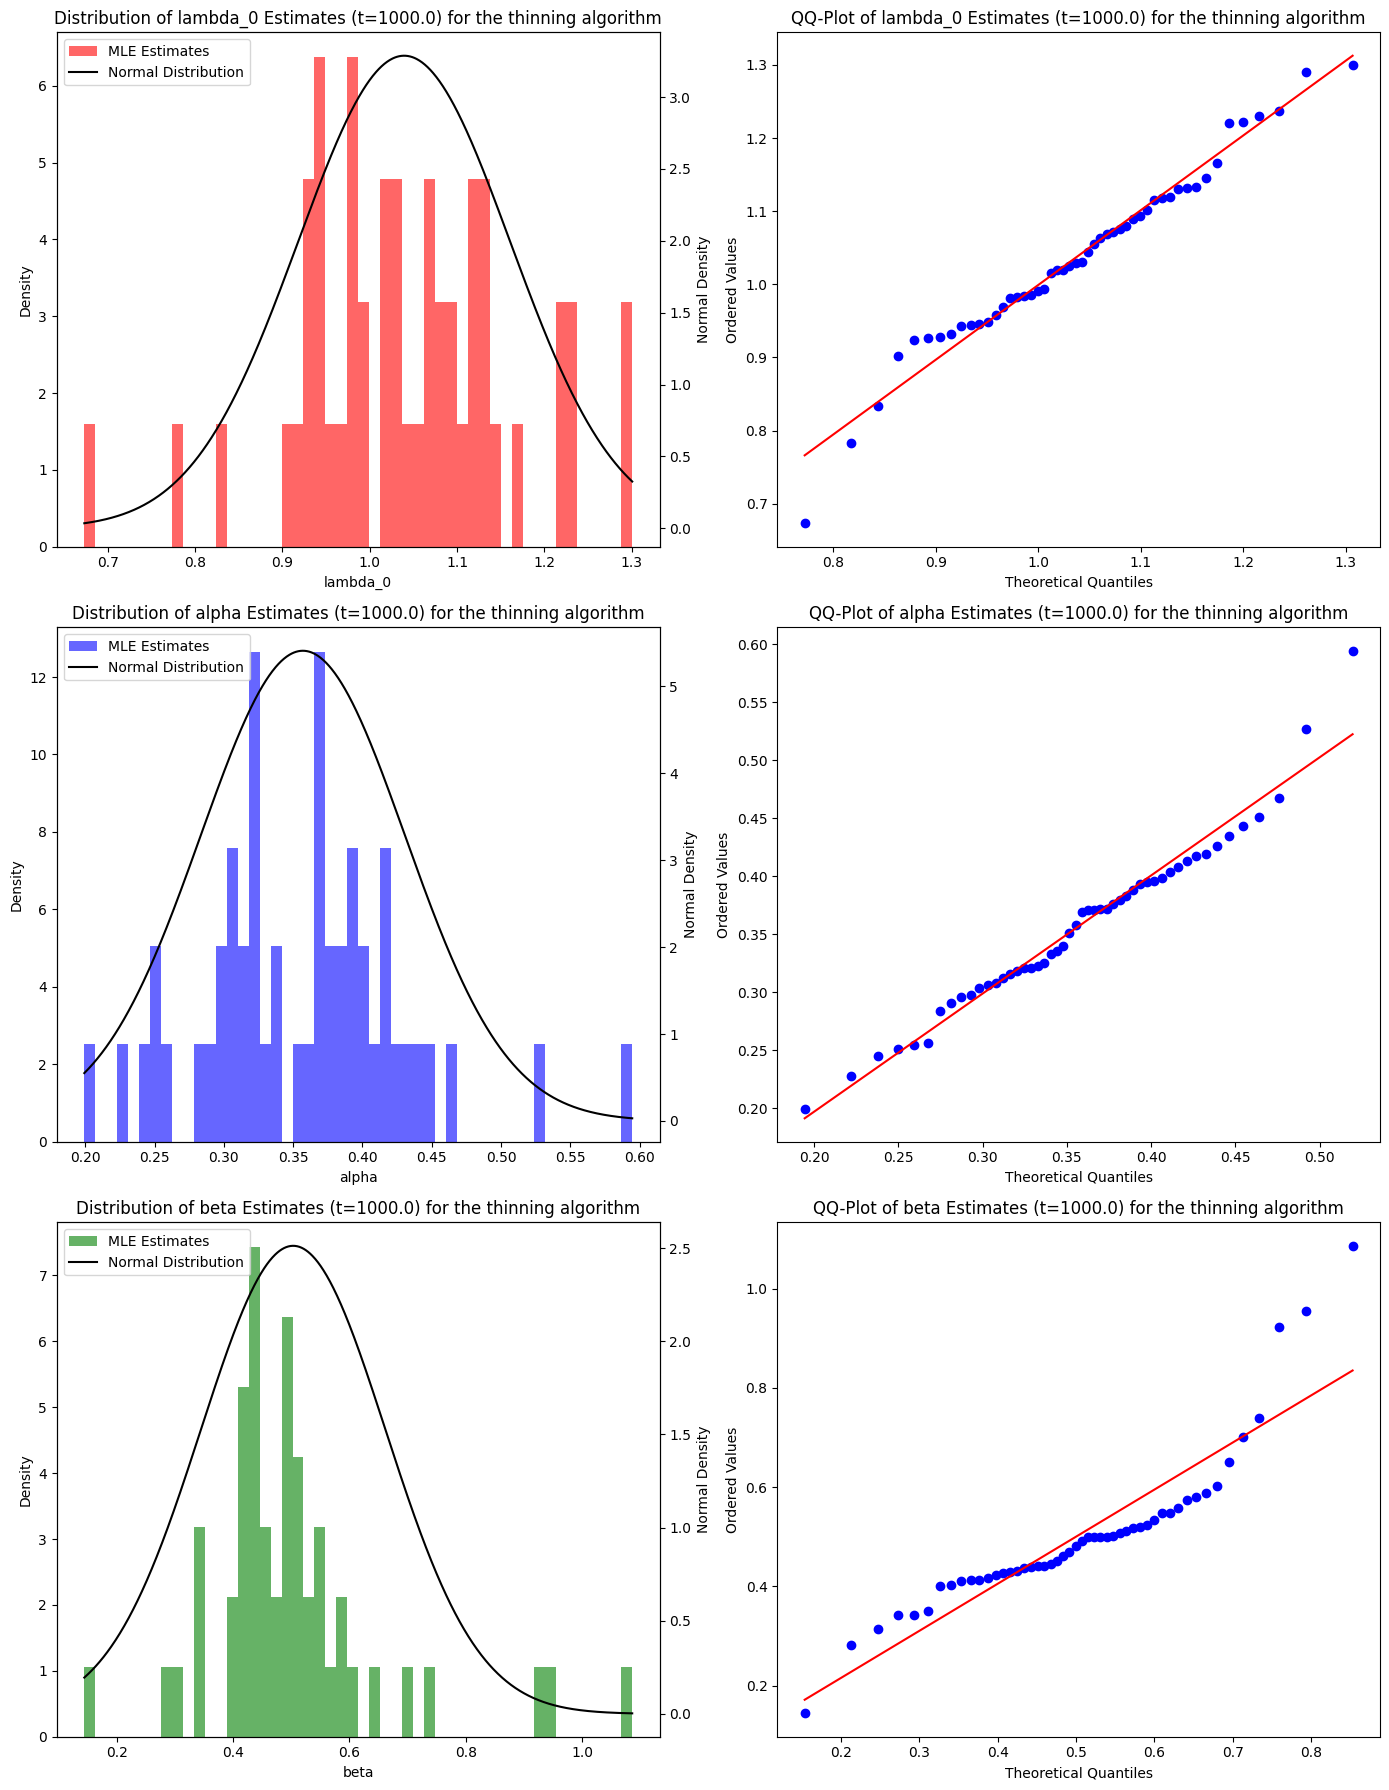

In [67]:
plot_asymptotic_normality(true_parameters, T_list, num_paths, "thinning", exponential_kernel, "exp")

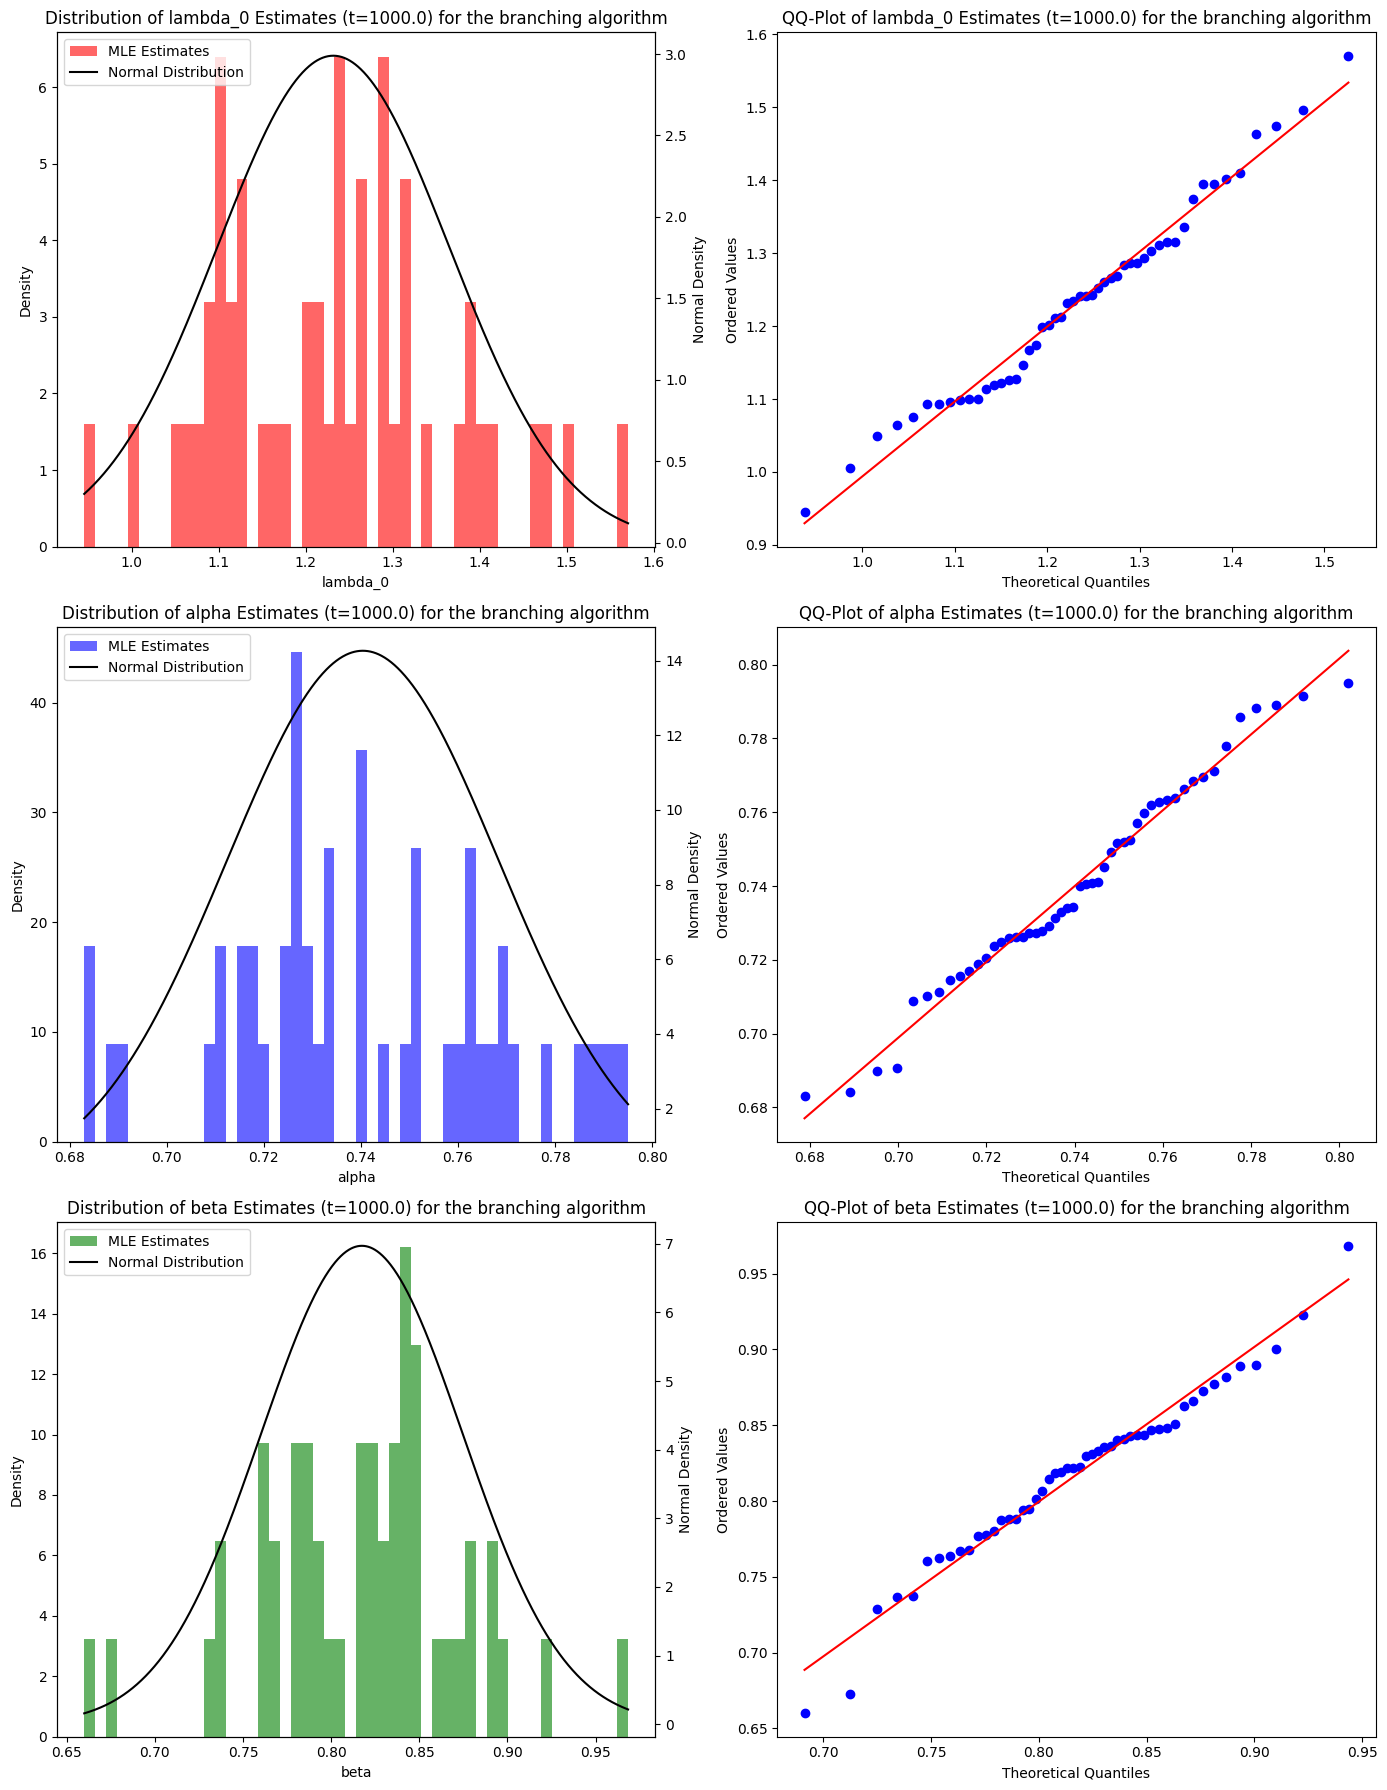

In [72]:
plot_asymptotic_normality(true_parameters, [T_list[-1]], num_paths, 
                          "branching", 
                          exponential_kernel, "exp") # for improved time

Comments : Those plots display the distribution of the three parameters using num_paths and ffor multiple time horizons values, for both thinning and branching algorithm. We have fit a normal distribution on top of the empirical one in order to check if the property of asymptotical normality is valid. Based on what we can observe, the more T increases and the better the normal distribution fits the empirical data, for all parameters. The branching algorithm seems to perform better in that sense. On top of this, we added a QQ-plot as a visual goodness-of-fit of the normal distribution for the parameters. The theoretical quantiles used are the ones of the normal distribution and the empirical ones, of our simulated data. We can also see a tendancy to fit better the theoretical line when the time horizon increases, but for QQ-plot, the more points the better so a general conclusion can be hard to draw in that case.

To have better results, we should increase the num_path to have more points on the distribution and also increase the time horizon, but both are slowing down our algorithms a lot.





Now, we are going to study deeper the computational cost of the two algorithms, and compare them with the implementation given by the library Hawkes.

Question 2 : **Computational cost of Hawkes simulators.** Compare for an exponential kernel the
 computational cost of your thinning algorithm, your branching algorithm, and the
 simulation of the Hawkes library. Estimate the complexity of these algorithm w.r.t. the
 horizon. Explain.

In [73]:
true_parameters_q2 = {'lambda_0': 1.2,'alpha': 0.6, 'beta': 0.8}

In [74]:
def library_simulation_exponential(T, true_params):
    """This function takes two arguments :
    - T : the time horizon of the simulation
    - true_params : the values of the true parameters lambda_0, alpha, beta
    It simulates a Hawkes process using the Hawkes library with the exponential kernel and the constant baseline. It returns a list of events of the Hawkes process."""
    # We used the tutorial in google colab made by Takahiro Omi
    model = hwk.simulator()
    model.set_kernel("exp")
    model.set_baseline("const")
    model.set_parameter(true_params)
    events = model.simulate([0,T])
    return events

In [84]:
def computational_cost_multiple_paths(kernel_func, T, num_iterations, true_params):
    """This function takes four arguments :
    - kernel_func : the kernel function used in the algorithm
    - T : the time horizon of the simulation
    - num_iterations : the number of iterations we want to do to compute the average time of the simulation
    - true_params : the values of the true parameters lambda_0, alpha, beta
    It returns the average time of the simulation for each algorithm (thinning, branching and library) in milliseconds."""
    true_para = {}
    for param in true_params.keys():
        inter = true_params[param]
        if param == 'lambda_0':
            param = 'mu'
        true_para[param] = inter

    start_time = pd.Timestamp.now()
    for _ in range(num_iterations):
        thinning_Hawkes_process(T, kernel_func)
    end_time = pd.Timestamp.now()
    time_thinning = (end_time - start_time).total_seconds() / num_iterations
    start_time = pd.Timestamp.now()
    for _ in range(num_iterations):
        branching_Hawkes_process(T, kernel_func)
    end_time = pd.Timestamp.now()
    time_branching = (end_time - start_time).total_seconds() / num_iterations
    start_time = pd.Timestamp.now()
    for _ in range(num_iterations):
        library_simulation_exponential(T, true_para)
    end_time = pd.Timestamp.now()
    time_library = (end_time - start_time).total_seconds() / num_iterations

    return time_thinning, time_branching, time_library

In [80]:
T = 500
time_thinning, time_branching, time_library = computational_cost_multiple_paths(exponential_kernel, T, num_paths, true_parameters)
print("### Computational Cost ###")
print(f"Thinning algorithm : {time_thinning:.3f} seconds per iteration")
print(f"Branching algorithm : {time_branching:.3f} seconds per iteration")
print(f"Hawkes library : {time_library:.3f} seconds per iteration")

1/3 done
2/3 done
3/3 done
### Computational Cost ###
Thinning algorithm : 0.425 seconds per iteration
Branching algorithm : 3.054 seconds per iteration
Hawkes library : 0.019 seconds per iteration


Comments : We can see that the Hawkes library implementation is the fastest. Then, our thinning algorithm is faster than the branching one (almost ten times) as we exploit the memoryless property of the exponential kernel and simplify the computation by saving part of the exponential kernel calculation.

But this is only a comparison of the computational cost of the three methods. Now, let's try to evaluate the complexity of these algorithms with respect to the time horizon.

In [89]:
def estimate_complexity(kernel_func, T_values, num_iterations, true_params):
    """This funtion takes four arguments :
    - kernel_func : the kernel function used in the algorithm
    - T_values : the list of time horizons that we will use to observe to convergence
    - num_iterations : the number of iterations we want to do to compute the average time of the simulation
    - true_params : the values of the true parameters lambda_0, alpha, beta
    It returns a list of the average time of the simulation for each algorithm (thinning, branching and library) in microseconds and in function of the time horizon used, and coming from the T_values array."""
    # We create three empty arrays to store the average computational times.
    thinning_times = []
    branching_times = []
    library_times = []
    # For each time horizon, we calcculate the computational time thanks to the function previously created.
    for T in T_values:
        time_thinning, time_branching, time_library = computational_cost_multiple_paths(kernel_func, T, num_iterations, true_params)
        thinning_times.append(time_thinning)
        branching_times.append(time_branching)
        library_times.append(time_library)
    return thinning_times, branching_times, library_times

In [86]:
def plot_estimate_complexity(thinning_times, branching_times, library_times):
    plt.figure(figsize=(12, 6))
    plt.plot(T_list, thinning_times, label='Thinning Algorithm', marker='o' ,color='blue')
    plt.plot(T_list, branching_times, label='Branching Algorithm', marker='o', color='red')
    plt.plot(T_list, library_times, label='Hawkes Library', marker='o', color='green')
    plt.plot(T_list, [t/1e4 for t in T_list], label='O(T)', color='black', linestyle='dotted')
    plt.plot(T_list, [t**2/1e4 for t in T_list], label='O($T^2$)', color='black', linestyle='dashdot')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Time Horizon (T)')
    plt.ylabel('Execution Time (seconds per iteration)')
    plt.title('Computational Complexity with Respect to Time Horizon')
    plt.legend()
    plt.grid()
    plt.show()

In [90]:
num_iterations = 10
thinning_times, branching_times, library_times = estimate_complexity(exponential_kernel, T_list, num_iterations, true_parameters)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:15,  1.72s/it]

 20%|██        | 2/10 [00:04<00:17,  2.14s/it]

 30%|███       | 3/10 [00:08<00:20,  2.94s/it]

 40%|████      | 4/10 [00:14<00:26,  4.36s/it]

 50%|█████     | 5/10 [00:25<00:33,  6.63s/it]

 60%|██████    | 6/10 [00:43<00:42, 10.63s/it]

 70%|███████   | 7/10 [01:15<00:52, 17.47s/it]

 80%|████████  | 8/10 [02:04<00:55, 27.66s/it]

 90%|█████████ | 9/10 [03:23<00:43, 43.67s/it]

100%|██████████| 10/10 [05:37<00:00, 33.70s/it]


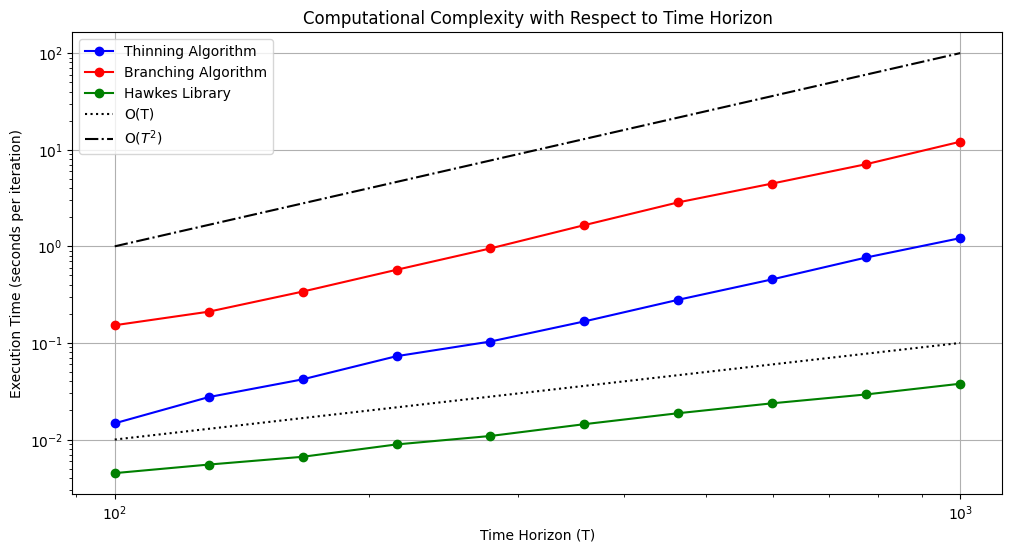

In [91]:
plot_estimate_complexity(thinning_times, branching_times, library_times)

Comments : This plot of the execution time in function of the time horizon shows that the thinning and the branching algorithms have a temporal complexity of $O(T^2)$ whereas the algorithm from the Hawkes library has a temporal complexity of $O(T)$. It appears on the plot that our intermediary conclusion that the branching algorithm was ten times slower than the thinning one is still valid. But their complexity both have the same dependency with respect to the time horizon as they increase with the square of it. To be more precise, we will try to get the exposant of the powerlaw of the three algorithms' complexity.

In [92]:
def estimate_power_law_exponent(times, sizes):
    """This function takes 2 parameters :
    - times: a list of computation times for different input sizes.
    - sizes: a list of the time horizons.
    It returns the estimated exponent of the power law."""
    log_times = numpy.log(times)
    log_sizes = numpy.log(sizes)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(log_sizes, log_times)
    return slope

exponent_thinning = estimate_power_law_exponent(thinning_times, T_list)
exponent_branching = estimate_power_law_exponent(branching_times, T_list)
exponent_library = estimate_power_law_exponent(library_times, T_list)

print(f"Estimated exponent for thinning algorithm: {exponent_thinning}")
print(f"Estimated exponent for branching algorithm: {exponent_branching}")
print(f"Estimated exponent for library algorithm: {exponent_library}")

Estimated exponent for thinning algorithm: 1.881941605376794
Estimated exponent for branching algorithm: 1.9479504005768753
Estimated exponent for library algorithm: 0.9420799229992924


Comments : Our observation on the plot is now confirmed. The exponent of the powerlaw for the library algorithm is really close to one and shows the complexity in $O(T^{1.02})$, while the exponent for the branching algorithm is really close to $O(T^2)$, in $O(T^{1.97})$. The thinning algorithm's computation cost is a bit less than the branching one, as it is in $O(T^{1.88})$.

The structure of the branching algorithm, generating new non-homogeneous poisson process for each point, until there is no point left, explains its complexity. Whereas the use of the memoryless structure of the exponential kernel explains that the algorithm is faster.

Question 3 : **A Hawkes process for trades.** Is a Hawkes process a good model for the time dynamics of the trades reported in your dataset ? Use statistical arguments to support your answers.

To check if the Hawkes process is a good model for the time dynamics of the trades reported in our dataset, we need to import the data, and estimate the parameters of Hawkes processes that would fit the data. Then, we can use some statistical arguments to determine whether or not this type of process is well-suited for the data we have.

In [100]:
data_path = "Data/SG/"
file_list = [
    "SG_20170117.csv.gz",
    "SG_20170118.csv.gz",
    "SG_20170119.csv.gz",
    "SG_20170120.csv.gz",
    "SG_20170123.csv.gz",
    "SG_20170124.csv.gz",
    "SG_20170125.csv.gz",
    "SG_20170126.csv.gz",
    "SG_20170127.csv.gz",
    "SG_20170130.csv.gz",
    "SG_20170131.csv.gz",
    "SG_20170201.csv.gz",
]
for file_path in file_list[:1]:    
    print(f"The estimations of the parameters for the file {file_path[3:-7]} are :")
    df = pd.read_csv(data_path + file_path)
    df.drop(df.columns[0], axis=1, inplace=True)
    df = df.loc[df['etype']=='T']
    df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
    real_path = (df['ets'] - df['ets'].values[0])
    real_path = numpy.array(real_path, dtype='float64')
    real_path = real_path / real_path[-1]
    print(MLE_parameters_estimations("empirical", exponential_kernel, "exp", 1 , real_path))

The estimations of the parameters for the file 20170117 are :
{'mu': np.float64(13774.9998049921), 'alpha': np.float64(50543427.29203711), 'beta': np.float64(5.574704497093667e-16)}


Comments : We displayed the parameters of Hawkes processes that would fit our data. But we have a problem. As our data is in nanoseconds, then a beta of $10^{−8}$ means that significant decay only occurs over time intervals on the order of $\frac{1}{\beta} \approx 10^8$ nanoseconds (around 0.1 seconds). As the events occur in rapid succession (much less than 0.1 seconds apart), then the kernel effectively acts as if it were constant over the observed intervals : indeed the exponential of the kernel would be : $e^{-\beta t} \approx 1$. Therefore, it seems to fail into capturing the data for almost all days except one. Let's deep dive into this day. 

We are going to try to display some statistical properties to check how the Hawkes process suits the data.


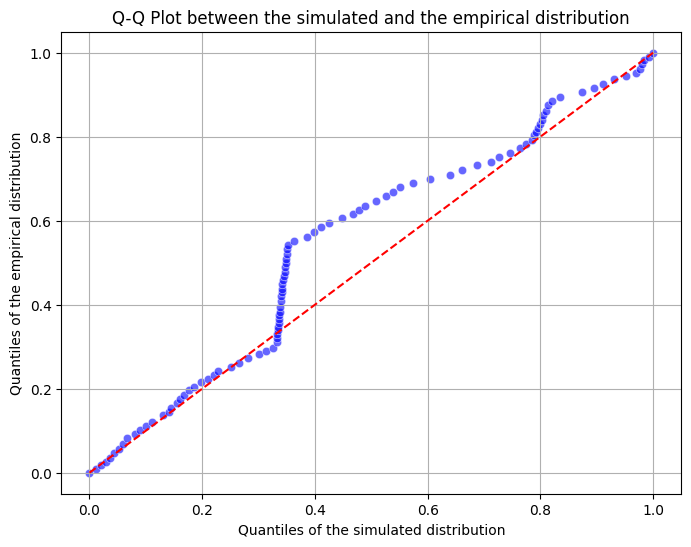

In [101]:
file_path = "SG_20170120.csv.gz"
df = pd.read_csv(data_path + file_path)
df.drop(df.columns[0], axis=1, inplace=True)
df = df.loc[df['etype']=='T']
df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
real_path = (df['ets'] - df['ets'].values[0])
real_path = numpy.array(real_path, dtype='float64')
real_path = real_path / real_path[-1]

true_params = MLE_parameters_estimations("empirical", exponential_kernel, "exp", 1 , real_path)

model = hwk.simulator()
model.set_kernel("exp")
model.set_baseline("const")
model.set_parameter(true_params)
simulated_path = model.simulate([0,1])

pct1 = numpy.percentile(real_path, numpy.linspace(0, 100, 100))
pct2 = numpy.percentile(simulated_path, numpy.linspace(0, 100, 100))
plt.figure(figsize=(8, 6))
plt.scatter(pct1, pct2, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Q-Q Plot between the simulated and the empirical distribution')
plt.xlabel('Quantiles of the simulated distribution')
plt.ylabel('Quantiles of the empirical distribution')
plt.grid(True)
plt.show()

Comments : This plot is a QQ-plot of the simulated distribution with the estimated parameters versus the empirical distribution of our data, for the choosen day. We can see that visually, the empirical distribution fails to be explained by the simulated one, which is the Hawkes process corresponding to the parameters obtained by estimation on the empirical data. Therefore, we could argue that this is not a good model for our data. But let's try to get a more quantitative analysis.

In [102]:
model_2 = hwk.estimator().set_kernel('exp').set_baseline('const')
model_2.fit(real_path, [0,1])
print("parameter:",model_2.parameter) 
print("branching ratio:",model_2.br) 
print("log-likelihood:",model_2.L)
print("AIC:",model_2.AIC) 

parameter: {'mu': np.float64(8698.67792373654), 'alpha': np.float64(0.5027337834080869), 'beta': np.float64(3836041484.160708)}
branching ratio: 0.5027337834080869
log-likelihood: 245975.47505884594
AIC: -491944.9501176919


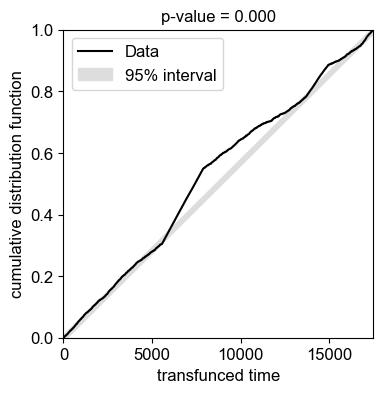

In [103]:
model_2.plot_KS()

Now, and to finish let's try to use the data of one hour and see if the Hawkes process models it better.

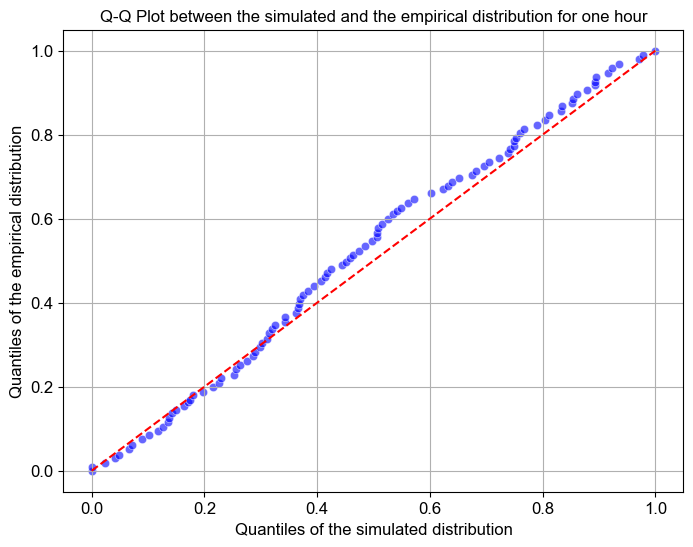

In [104]:
file_path = "SG_20170120.csv.gz"
df = pd.read_csv(data_path + file_path)
df.drop(df.columns[0], axis=1, inplace=True)
df = df.loc[df['etype']=='T']
df['ets'] = pd.to_datetime(df['ets'], format="%Y%m%d:%H:%M:%S.%f")
start_time = df['ets'].iloc[0]
end_time = start_time + pd.Timedelta(hours=1)

df = df.loc[df['ets'] <= end_time]

real_path_2 = (df['ets'] - start_time)
real_path_2 = numpy.array(real_path_2, dtype='float64')
real_path_2 = real_path_2 / real_path_2[-1]

true_params = MLE_parameters_estimations("empirical", exponential_kernel, "exp", 1 , real_path)

model_3 = hwk.simulator()
model_3.set_kernel("exp")
model_3.set_baseline("const")
model_3.set_parameter(true_params)
simulated_path_2 = model_3.simulate([0,1])

pct1 = numpy.percentile(real_path_2, numpy.linspace(0, 100, 100))
pct2 = numpy.percentile(simulated_path_2, numpy.linspace(0, 100, 100))
plt.figure(figsize=(8, 6))
plt.scatter(pct1, pct2, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Q-Q Plot between the simulated and the empirical distribution for one hour')
plt.xlabel('Quantiles of the simulated distribution')
plt.ylabel('Quantiles of the empirical distribution')
plt.grid(True)
plt.show()

Comments : This plot is a QQ-plot of the simulated distribution with the estimated parameters versus the empirical distribution of our data, for the choosen hour. We can see that visually, the empirical distribution is better explained by the simulated one, which is the Hawkes process corresponding to the parameters obtained by estimation on the empirical data. Therefore, we could argue that this is a better model for our data. Let's try to get a more quantitative analysis.

In [105]:
model_4 = hwk.estimator().set_kernel('exp').set_baseline('const')
model_4.fit(real_path_2, [0,1])
print("parameter:",model_4.parameter) 
print("branching ratio:",model_4.br) 
print("log-likelihood:",model_4.L)
print("AIC:",model_4.AIC) 

parameter: {'mu': np.float64(2186.999999413247), 'alpha': np.float64(2.4075494087611577), 'beta': np.float64(3.974914501344919e-09)}
branching ratio: 2.4075494087611577
log-likelihood: 14631.655526722518
AIC: -29257.311053445035


Comments : We can see that the parameters estimated for the hour data are better than the ones estimated for the whole day. The branching ratio is closer to 1 and the AIC is lower. The log-likelihood is also higher. This means that the model fits better the data for the hour than for the whole day. Therefore, we could argue that the Hawkes process is a good model for the time dynamics of the trades reported in our dataset, but only for short time intervals. For longer time intervals, the Hawkes process is not a good model for the data.

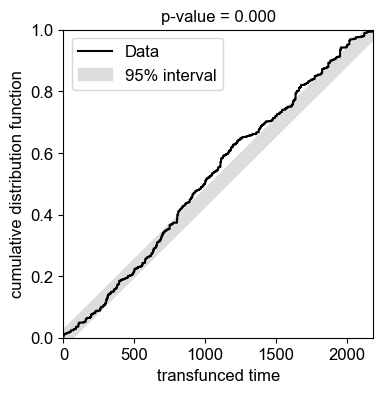

In [106]:
model_4.plot_KS()